In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install torchmetrics
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 47.7 MB/s eta 0:00:00


In [ ]:
# !rm -r Training
# !rm -r Testing
# !rm -r dataset.zip
# !unzip dataset.zip

In [ ]:
import kagglehub

path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print(path)

100%|██████████| 86.8M/86.8M [00:04<00:00, 18.5MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from google.colab import drive
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms
from torchmetrics import AUROC

import matplotlib.pyplot as plt
import seaborn as sns

from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize
)
from monai.utils import set_determinism
import random

generator = random.Random()

set_determinism(seed=44)
fgbg = cv2.createBackgroundSubtractorMOG2()

classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

def get_image_list(data_dir):
  image_paths = []
  labels = []

  for class_name in os.listdir(data_dir):
      class_dir = os.path.join(data_dir, class_name)
      if os.path.isdir(class_dir):
        if class_name == 'glioma_tumor':
          label = 0
        elif class_name == 'meningioma_tumor':
          label = 1
        elif class_name == 'no_tumor':
          label = 2
        elif class_name == 'pituitary_tumor':
          label = 3
        else:
          continue

        for image_name in os.listdir(class_dir):
          image_path = os.path.join(class_dir, image_name)
          image_paths.append(image_path)
          labels.append(label)
  return image_paths, labels

# Cerinta 1

class BrainTumorDataset(Dataset):
  def __init__(self, image_paths, labels, transforms, type_set):
    self.image_paths, self.labels, self.transforms, self.type_set = image_paths, labels, transforms, type_set

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = cv2.imread(image_path)

    image = self.transforms(image)

    return image, label



In [ ]:
  # Cerinta 2

  def get_splited_train_data(val_frac = 0.2, train_frac = 0.8):
    image_paths, labels = get_image_list(path + "/Training")
    length = len(image_paths)
    train_length = int(train_frac * length)
    indices = np.arange(length)
    np.random.shuffle(indices)

    val_split = int(val_frac * length)
    val_indices = indices[:val_split]
    train_indices = indices[val_split:train_length]

    train_x = [image_paths[i] for i in train_indices]
    train_y = [labels[i] for i in train_indices]

    val_x = [image_paths[i] for i in val_indices]
    val_y = [labels[i] for i in val_indices]

    return train_x, train_y, val_x, val_y
  def get_test_data():
    image_paths, labels = get_image_list(path +"/Testing")
    return image_paths, labels

**TEMA 2**

**Incarcarea datelor**

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as F

class Transform_to_apply:
  def __call__(self, image):

    image = resize_image(image)
    image = GaussianBlur(image)
    image = apply_clahe(image)

    image = Image.fromarray(image)

    return image

def GaussianBlur(image_cv2):
  blurred_image = cv2.GaussianBlur(image_cv2, (5, 5), 1.0)
  return blurred_image


def sobel_edge_detection(image_cv2):
  grad_x = cv2.Sobel(image_cv2, cv2.CV_64F, 1, 0, ksize=3)
  grad_y = cv2.Sobel(image_cv2, cv2.CV_64F, 0, 1, ksize=3)

  gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

  gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

  return gradient_magnitude

def apply_clahe(image_cv2):
  import albumentations as A

  cl = A.CLAHE(p=1)
  clahe = cl(image=image_cv2)["image"]

  return clahe

def background_subtract(image_cv2):
  img = fgbg.apply(image_cv2)

  return img

def resize_image(image_cv2):
   image_cv2 = cv2.resize(image_cv2, (224, 224))
   return image_cv2

transforms_train = transforms.Compose([
    Transform_to_apply(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(60),
    transforms.ToTensor()
])

transforms_test = transforms.Compose([
    Transform_to_apply(),
    transforms.ToTensor()
])

In [ ]:
from sklearn.model_selection import StratifiedKFold

def stratified_k_fold_split(X, y, k=5):
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # Use a random state for reproducibility
  folds = []
  for train_index, val_index in skf.split(X, y):
    folds.append((train_index, val_index))
  return folds

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

def train_model(train_x, train_y, val_x, val_y, test_x, test_y, loss_function, transforms_for_train, transforms_for_test):
    # Create datasets and dataloaders for this fold
    train_ds = BrainTumorDataset(train_x, train_y, transforms_for_train, "train")
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_ds = BrainTumorDataset(val_x, val_y, transforms_for_train, "validation")
    val_loader = DataLoader(val_ds, batch_size=32)
    test_ds = BrainTumorDataset(test_x, test_y, transforms_for_test, "test")
    test_loader = DataLoader(test_ds, batch_size=32)

    # Initialize the model, optimizer, loss function (same as before)
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 4)

    use_cuda = torch.cuda.is_available()
    device = "cuda"

    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    loss_function = loss_function

    # Training loop (similar to your existing code but with modifications for fold number)
    epochs = 10
    auroc = AUROC(task="multiclass", num_classes=4, average='weighted')
    auroc = auroc.to(device)

    train_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    validation_accuracy_list = []
    performance_epoch = []

    validation_f1_list= []
    validation_precision_list = []
    validation_recall_list = []

    y_true = []
    y_pred = []

    best_performance = 0
    for epoch in range(epochs):
      print("-" * 10)
      print(f"epoch {epoch + 1}/{epochs}")
      model.train()
      epoch_loss = 0
      correct_train_preds = 0
      total_train_samples = 0
      step = 0
      for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        # Reset the b value
        optimizer.zero_grad()
        # Delete the extra dimension
        inputs = inputs.squeeze(1)
        outputs = model(inputs.float())
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

        _, predicted = torch.max(outputs.data, 1)
        correct_train_preds += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

      train_accuracy = correct_train_preds / total_train_samples
      train_accuracy_list.append(train_accuracy)

      epoch_loss /= step
      print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
      train_loss_list.append(epoch_loss)

      # Validation loop
      model.eval()
      val_loss = 0
      val_acc = 0
      total_val_samples = 0
      probabilities = []
      targets = []
      with torch.no_grad():
        for data, target in val_loader:
          data, target = data.to(device), target.to(device)
          data = data.squeeze(1)
          output = model(data.float())
          loss = loss_function(output, target)
          val_loss += loss.item()

          _, predicted = torch.max(output.data, 1)
          val_acc += (predicted == target).sum().item()
          total_val_samples += target.size(0)

          probs = torch.softmax(output, dim=1)
          probabilities.append(probs)
          targets.append(target)


      validation_accuracy = val_acc / total_val_samples
      validation_accuracy_list.append(validation_accuracy)

      validation_precision_list.append(precision_score(y_true, y_pred, average='weighted'))
      validation_recall_list.append(recall_score(y_true, y_pred, average='weighted'))
      validation_f1_list.append(f1_score(y_true, y_pred, average='weighted'))

      probabilities = torch.cat(probabilities)
      targets = torch.cat(targets)

      performance = auroc(probabilities, targets)
      print(f"Performance: {performance:.4f}")
      performance_epoch.append(performance)
      # if performance > best_performance:
      #   best_performance = performance
      #   torch.save(model.state_dict(), "best_metric_model.pth")
      #   print(f"New best Performance!: {best_performance:.4f}")

      print(f"Validation Loss: {val_loss/len(val_loader)}")
      validation_loss_list.append(val_loss/len(val_loader))


    # TESTARE

    model.eval()
    y_test_true = []
    y_test_pred = []
    probs_test = []
    targets_test = []
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = data.squeeze(1)
        output = model(data.float())
        loss = loss_function(output, target)
        val_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        val_acc += (predicted == target).sum().item()

        y_test_true.extend(target.cpu().numpy())
        y_test_pred.extend(predicted.cpu().numpy())

        probs = torch.softmax(output, dim=1)
        probs_test.append(probs)
        targets_test.append(target)

      print(f"Testing Loss: {val_loss/len(test_loader)}, Testing Accuracy: {val_acc/len(test_ds)}")


    probs_test = torch.cat(probs_test)
    targets_test = torch.cat(targets_test)

    performance = auroc(probs_test, targets_test)

    #Performante pe setul de testare
    accuracy = val_acc/len(test_ds)
    precision = precision_score(y_test_true, y_test_pred, average='weighted')
    recall = recall_score(y_test_true, y_test_pred, average='weighted')
    f1 = f1_score(y_test_true, y_test_pred, average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Performance: {performance}")

    # cm = confusion_matrix(y_test_true, y_test_pred)

    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.title('Confusion Matrix')
    # plt.show()

    return performance, accuracy, precision, recall, f1, validation_accuracy_list, validation_precision_list, validation_recall_list, validation_f1_list, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list





**Cerinta 2.1**

Training fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3969
2/57, train_loss: 1.3613
3/57, train_loss: 1.4335
4/57, train_loss: 1.5757
5/57, train_loss: 1.2311
6/57, train_loss: 1.2346
7/57, train_loss: 1.5845
8/57, train_loss: 1.2250
9/57, train_loss: 1.2923
10/57, train_loss: 1.4222
11/57, train_loss: 0.5762
12/57, train_loss: 0.7954
13/57, train_loss: 1.0409
14/57, train_loss: 0.8304
15/57, train_loss: 0.5116
16/57, train_loss: 0.8470
17/57, train_loss: 0.8961
18/57, train_loss: 1.2584
19/57, train_loss: 0.8548
20/57, train_loss: 1.0211
21/57, train_loss: 0.4986
22/57, train_loss: 0.2017
23/57, train_loss: 0.8856
24/57, train_loss: 1.7622
25/57, train_loss: 0.8730
26/57, train_loss: 0.5068
27/57, train_loss: 0.9939
28/57, train_loss: 0.8893
29/57, train_loss: 0.6990
30/57, train_loss: 0.9259
31/57, train_loss: 1.0118
32/57, train_loss: 0.9365
33/57, train_loss: 0.4481
34/57, train_loss: 0.5938
35/57, train_loss: 1.1704
36/57, train_loss: 0.7733
37/57, train_loss: 0.5065
38/57, train_loss: 1.1229

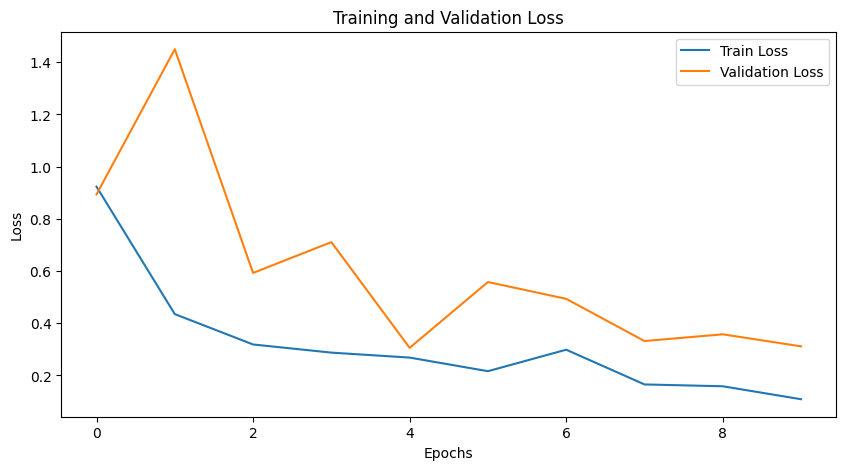

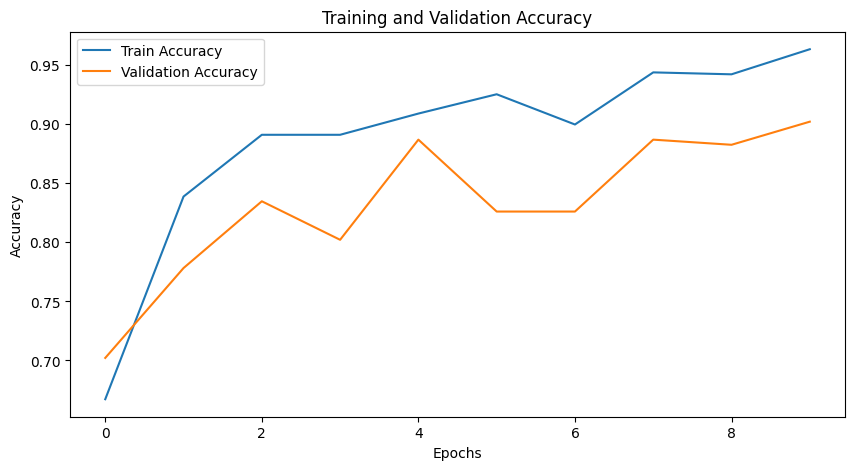

Training fold 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3435
2/57, train_loss: 1.2956
3/57, train_loss: 1.1715
4/57, train_loss: 1.2476
5/57, train_loss: 1.2737
6/57, train_loss: 1.1490
7/57, train_loss: 1.0787
8/57, train_loss: 1.3970
9/57, train_loss: 1.1510
10/57, train_loss: 1.2274
11/57, train_loss: 0.6492
12/57, train_loss: 1.0881
13/57, train_loss: 0.8930
14/57, train_loss: 0.5995
15/57, train_loss: 0.4701
16/57, train_loss: 0.2443
17/57, train_loss: 0.7468
18/57, train_loss: 0.9853
19/57, train_loss: 0.6483
20/57, train_loss: 0.6986
21/57, train_loss: 0.3968
22/57, train_loss: 1.5585
23/57, train_loss: 1.2580
24/57, train_loss: 0.5717
25/57, train_loss: 0.7461
26/57, train_loss: 1.6620
27/57, train_loss: 0.4392
28/57, train_loss: 0.8952
29/57, train_loss: 0.6715
30/57, train_loss: 0.7475
31/57, train_loss: 0.3337
32/57, train_loss: 0.9894
33/57, train_loss: 0.6002
34/57, train_loss: 1.2393
35/57, train_loss: 0.5204
36/57, train_loss: 1.7845
37/57, train_loss: 0.4343
38/57, train_loss: 0.9285

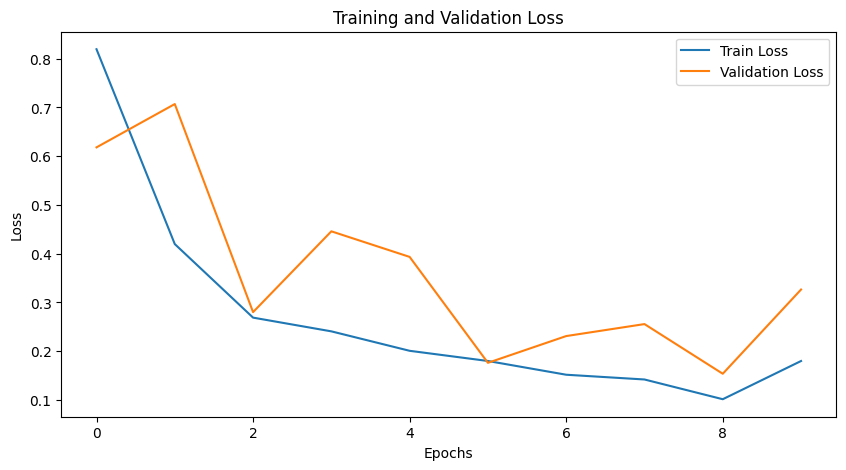

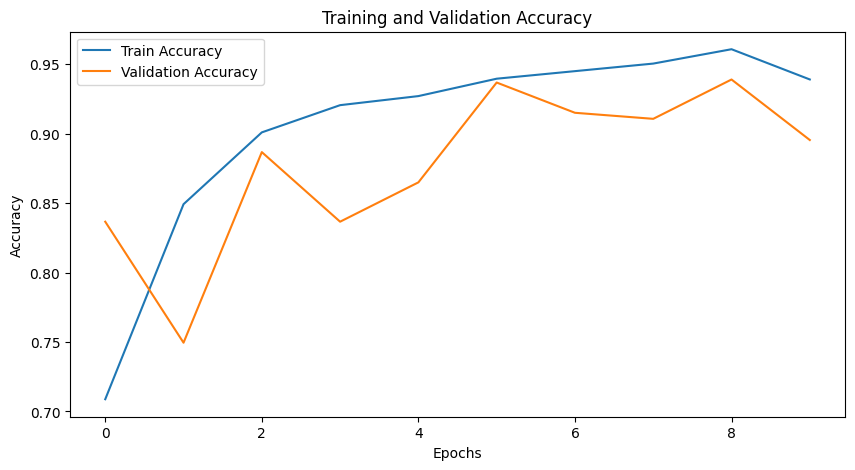

Training fold 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.4037
2/57, train_loss: 1.3119
3/57, train_loss: 1.4652
4/57, train_loss: 1.2821
5/57, train_loss: 1.4539
6/57, train_loss: 1.4603
7/57, train_loss: 1.4438
8/57, train_loss: 0.9627
9/57, train_loss: 1.0123
10/57, train_loss: 0.8592
11/57, train_loss: 0.8075
12/57, train_loss: 0.6923
13/57, train_loss: 0.8662
14/57, train_loss: 0.5430
15/57, train_loss: 0.7151
16/57, train_loss: 0.8552
17/57, train_loss: 0.6942
18/57, train_loss: 0.6481
19/57, train_loss: 1.1706
20/57, train_loss: 0.4768
21/57, train_loss: 0.6730
22/57, train_loss: 1.0980
23/57, train_loss: 0.8377
24/57, train_loss: 0.6797
25/57, train_loss: 0.9397
26/57, train_loss: 0.7387
27/57, train_loss: 0.7288
28/57, train_loss: 0.8059
29/57, train_loss: 0.9739
30/57, train_loss: 0.6389
31/57, train_loss: 1.3948
32/57, train_loss: 1.0858
33/57, train_loss: 0.7233
34/57, train_loss: 0.9326
35/57, train_loss: 0.5937
36/57, train_loss: 1.1709
37/57, train_loss: 1.2206
38/57, train_loss: 0.7861

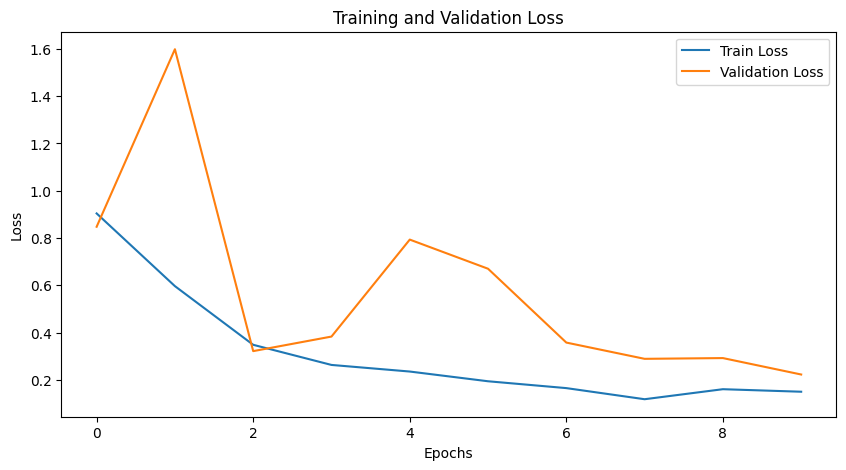

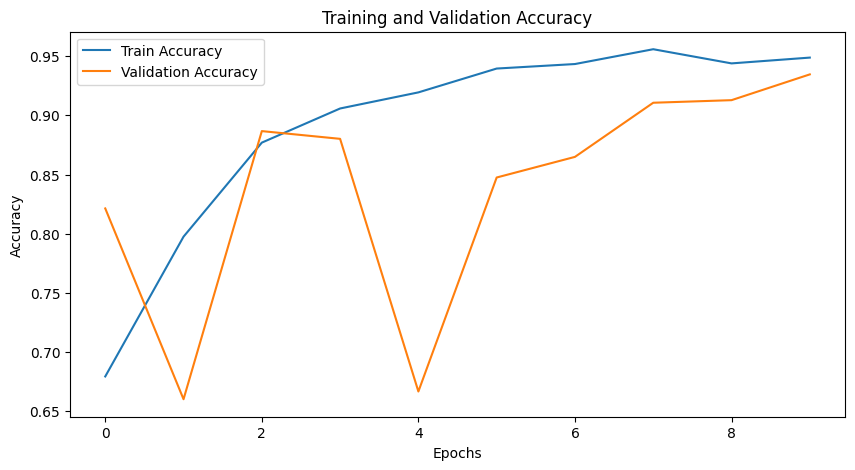

Training fold 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3787
2/57, train_loss: 1.4046
3/57, train_loss: 1.3143
4/57, train_loss: 1.3481
5/57, train_loss: 1.4279
6/57, train_loss: 1.1662
7/57, train_loss: 1.0695
8/57, train_loss: 1.3751
9/57, train_loss: 0.7141
10/57, train_loss: 0.6896
11/57, train_loss: 0.8773
12/57, train_loss: 0.7289
13/57, train_loss: 0.6286
14/57, train_loss: 0.6552
15/57, train_loss: 1.1478
16/57, train_loss: 0.3048
17/57, train_loss: 0.5440
18/57, train_loss: 0.5472
19/57, train_loss: 0.7119
20/57, train_loss: 0.2977
21/57, train_loss: 0.6599
22/57, train_loss: 0.4628
23/57, train_loss: 0.6120
24/57, train_loss: 0.3967
25/57, train_loss: 0.1898
26/57, train_loss: 0.4403
27/57, train_loss: 0.4892
28/57, train_loss: 0.4883
29/57, train_loss: 0.4508
30/57, train_loss: 0.6406
31/57, train_loss: 0.9127
32/57, train_loss: 0.1218
33/57, train_loss: 0.6866
34/57, train_loss: 0.5492
35/57, train_loss: 0.9053
36/57, train_loss: 1.6970
37/57, train_loss: 0.6049
38/57, train_loss: 0.5511

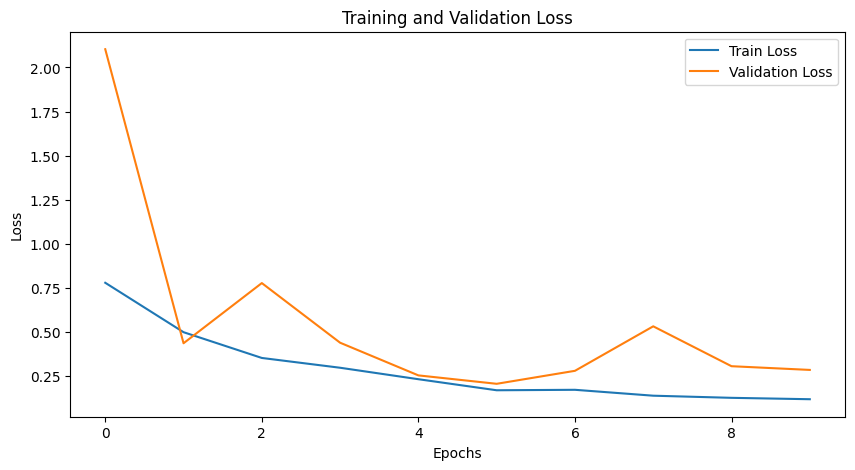

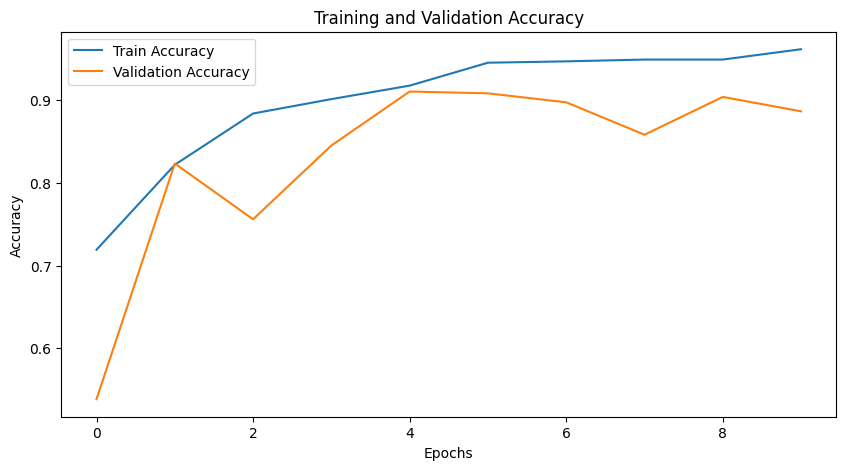

Training fold 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3692
2/57, train_loss: 1.3911
3/57, train_loss: 1.4027
4/57, train_loss: 1.4329
5/57, train_loss: 1.2916
6/57, train_loss: 1.1631
7/57, train_loss: 1.9769
8/57, train_loss: 0.7016
9/57, train_loss: 1.4228
10/57, train_loss: 1.0485
11/57, train_loss: 0.5992
12/57, train_loss: 0.6226
13/57, train_loss: 1.0905
14/57, train_loss: 1.1259
15/57, train_loss: 0.4688
16/57, train_loss: 1.0437
17/57, train_loss: 0.8341
18/57, train_loss: 0.6456
19/57, train_loss: 1.2417
20/57, train_loss: 0.5643
21/57, train_loss: 0.7301
22/57, train_loss: 0.1475
23/57, train_loss: 0.6319
24/57, train_loss: 1.1056
25/57, train_loss: 0.5602
26/57, train_loss: 1.0246
27/57, train_loss: 1.3852
28/57, train_loss: 0.7425
29/57, train_loss: 1.0774
30/57, train_loss: 1.1464
31/57, train_loss: 0.5188
32/57, train_loss: 1.0147
33/57, train_loss: 0.3739
34/57, train_loss: 0.3763
35/57, train_loss: 0.9503
36/57, train_loss: 1.0119
37/57, train_loss: 1.0390
38/57, train_loss: 0.6115

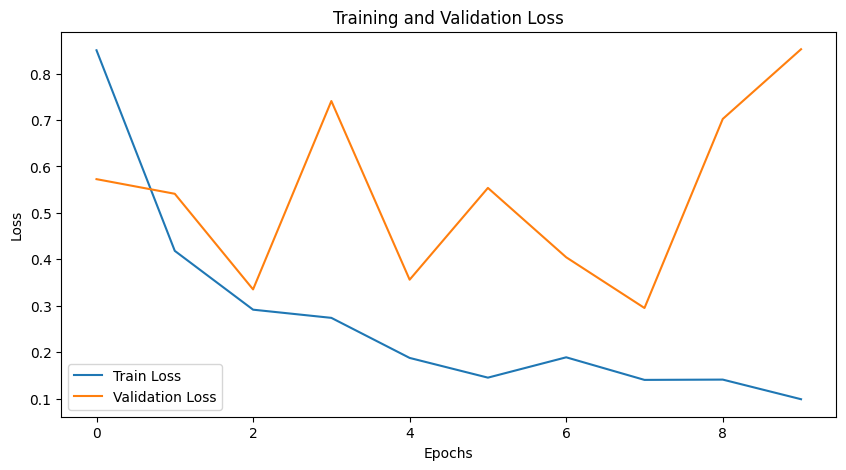

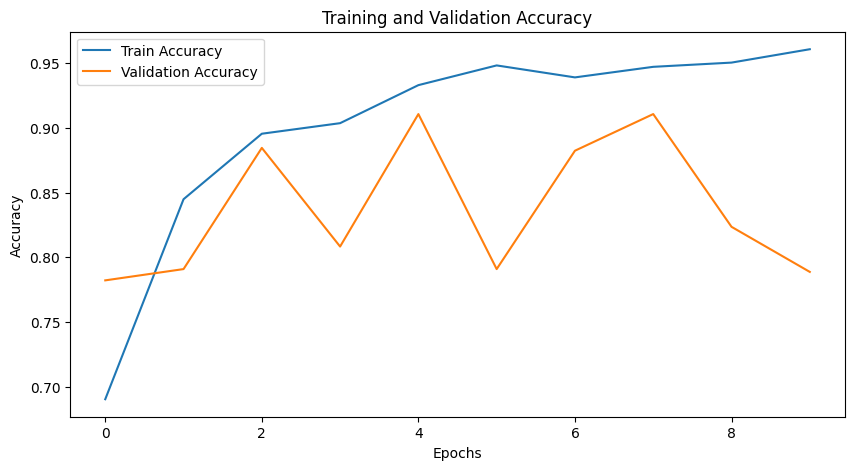

In [ ]:
# Data
train_x, train_y, val_x, val_y = get_splited_train_data()
test_x, test_y = get_test_data()


# Stratified K-Fold
folds = stratified_k_fold_split(train_x + val_x, train_y + val_y, k=5)

all_test_acc = []
all_test_precision = []
all_test_recall = []
all_test_f1 = []

all_validation_acc = {}
all_validation_precision ={}
all_validation_recall = {}
all_validation_f1={}

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for fold_num, (train_index, val_index) in enumerate(folds):
  print(f"Training fold {fold_num + 1}")
  # Creăm seturile de antrenare și validare pentru acest fold

  all_x = train_x + val_x
  all_y = train_y + val_y
  fold_train_x = [all_x[i] for i in train_index]
  fold_train_y = [all_y[i] for i in train_index]
  fold_val_x = [all_x[i] for i in val_index]
  fold_val_y = [all_y[i] for i in val_index]

  test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, validation_precision_list, \
  validation_recall_list, validation_f1_list, train_loss_list, validation_loss_list, \
  train_accuracy_list, validation_accuracy_list= train_model(
      fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, nn.CrossEntropyLoss(), transforms_train, transforms_test)

  all_test_acc.append(test_acc)
  all_test_precision.append(test_precision)
  all_test_recall.append(test_recall)
  all_test_f1.append(test_f1)
  all_validation_acc[fold_num + 1] = validation_acc_list
  all_validation_precision[fold_num + 1] = validation_precision_list
  all_validation_recall[fold_num + 1]= validation_recall_list
  all_validation_f1[fold_num + 1] = validation_f1_list

  # Ploturi loss si acc pentru antrenare si validare
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss_list, label='Train Loss')
  plt.plot(validation_loss_list, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('training_validation_loss' + str(fold_num + 1) +'.png')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracy_list, label='Train Accuracy')
  plt.plot(validation_accuracy_list, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('training_validation_accuracy' + str(fold_num + 1) +'.png')
  plt.show()




In [ ]:
import numpy as np

# Calculate mean and standard deviation for each list
def calculate_stats(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    return mean, std_dev

# Testare
# Creează numerele foldurilor
fold_numbers = list(range(1, len(all_test_acc) + 1))

# Crează DataFrame-ul pentru valorile fold-urilor
data = {
    "Fold": fold_numbers,
    "Accuracy": all_test_acc,
    "Precision": all_test_precision,
    "Recall": all_test_recall,
    "F1-Score": all_test_f1,
}

df = pd.DataFrame(data)

# Calculează media și abaterea standard pentru fiecare metrică
metrics = {
    "Accuracy": all_test_acc,
    "Precision": all_test_precision,
    "Recall": all_test_recall,
    "F1-Score": all_test_f1,
}

mean_std_data = {
    "Metric": [],
    "Mean": [],
    "StdDev": []
}

for metric_name, values in metrics.items():
    mean, std_dev = calculate_stats(values)
    mean_std_data["Metric"].append(metric_name)
    mean_std_data["Mean"].append(mean)
    mean_std_data["StdDev"].append(std_dev)

mean_std_df = pd.DataFrame(mean_std_data)

# Afișează rezultatele
print("Fold Test Metrics:")
print(df)
print("\nMean and StdDev for Test Metrics:")
print(mean_std_df)
print("\n")

data = {
  'Fold': list(range(1, len(all_test_acc) + 1)),
  'Validation Accuracy Mean': [],
  'Validation Accuracy StdDev': [],
  'Validation Precision Mean': [],
  'Validation Precision StdDev': [],
  'Validation Recall Mean': [],
  'Validation Recall StdDev': [],
  'Validation F1 Mean': [],
  'Validation F1 StdDev': [],
}

for fold_num, (train_index, val_index) in enumerate(folds):
  i = fold_num + 1
  # Calculate and prin statistics Validare
  acc_mean, acc_std = calculate_stats(all_validation_acc[i])
  precision_mean, precision_std = calculate_stats(all_validation_precision[i])
  recall_mean, recall_std = calculate_stats(all_validation_recall[i])
  f1_mean, f1_std = calculate_stats(all_validation_f1[i])

  data["Validation Accuracy Mean"] += [acc_mean]
  data["Validation Accuracy StdDev"] += [acc_std]
  data["Validation Precision Mean"] += [precision_mean]
  data["Validation Precision StdDev"] += [precision_std]
  data["Validation Recall Mean"] += [recall_mean]
  data["Validation Recall StdDev"] += [recall_std]
  data["Validation F1 Mean"] += [f1_mean]
  data["Validation F1 StdDev"] += [f1_std]

df = pd.DataFrame(data)

print(df)

Fold Test Metrics:
   Fold  Accuracy  Precision    Recall  F1-Score
0     1  0.690355   0.704260  0.690355  0.669004
1     2  0.639594   0.748941  0.639594  0.578489
2     3  0.708122   0.745631  0.708122  0.680464
3     4  0.682741   0.813689  0.682741  0.649013
4     5  0.555838   0.713220  0.555838  0.535677

Mean and StdDev for Test Metrics:
      Metric      Mean    StdDev
0   Accuracy  0.655330  0.054610
1  Precision  0.745148  0.038480
2     Recall  0.655330  0.054610
3   F1-Score  0.622529  0.056037


   Fold  Validation Accuracy Mean  Validation Accuracy StdDev  \
0     1                  0.832826                    0.058506   
1     2                  0.877124                    0.054876   
2     3                  0.838562                    0.092982   
3     4                  0.832898                    0.108452   
4     5                  0.837255                    0.050777   

   Validation Precision Mean  Validation Precision StdDev  \
0                   0.822962     

**Cerinta 2.2**

**Functia de pierdere cu ponderi**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/53, train_loss: 1.3425
2/53, train_loss: 1.3676
3/53, train_loss: 1.2938
4/53, train_loss: 1.2034
5/53, train_loss: 1.4971
6/53, train_loss: 1.1461
7/53, train_loss: 1.4025
8/53, train_loss: 0.9932
9/53, train_loss: 0.9400
10/53, train_loss: 1.3395
11/53, train_loss: 0.7955
12/53, train_loss: 0.6220
13/53, train_loss: 0.6582
14/53, train_loss: 0.4557
15/53, train_loss: 0.6991
16/53, train_loss: 1.2236
17/53, train_loss: 0.4547
18/53, train_loss: 0.5302
19/53, train_loss: 0.6147
20/53, train_loss: 0.8138
21/53, train_loss: 0.5923
22/53, train_loss: 0.7407
23/53, train_loss: 0.7817
24/53, train_loss: 0.5708
25/53, train_loss: 0.6489
26/53, train_loss: 0.5540
27/53, train_loss: 0.4166
28/53, train_loss: 0.6090
29/53, train_loss: 0.7378
30/53, train_loss: 0.6984
31/53, train_loss: 0.7238
32/53, train_loss: 0.3755
33/53, train_loss: 0.9711
34/53, train_loss: 0.6053
35/53, train_loss: 0.5471
36/53, train_loss: 0.5524
37/53, train_loss: 0.5680
38/53, train_loss: 0.2603

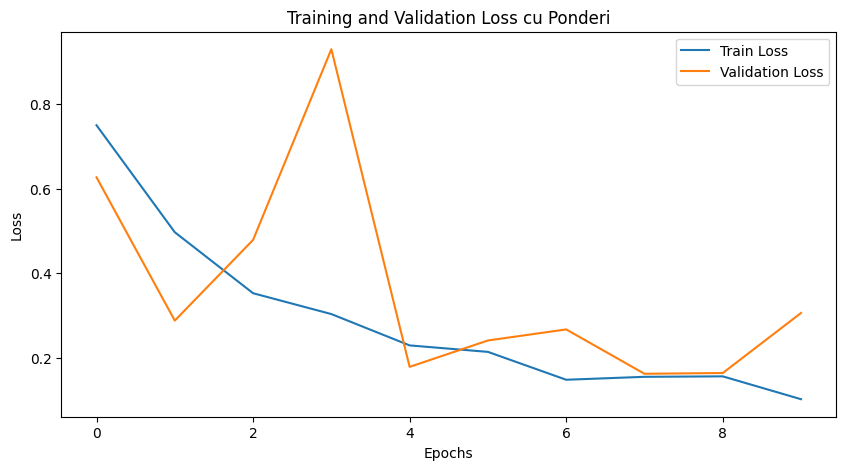

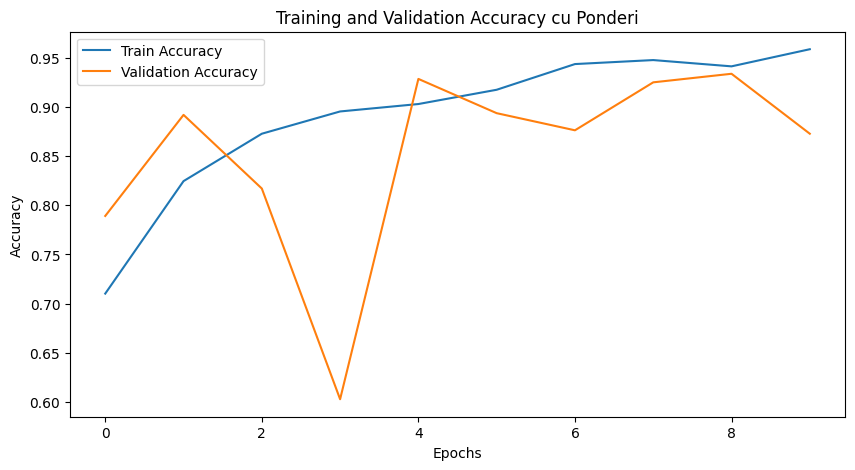

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/53, train_loss: 1.3633
2/53, train_loss: 1.3591
3/53, train_loss: 1.3348
4/53, train_loss: 1.3090
5/53, train_loss: 1.3021
6/53, train_loss: 1.3299
7/53, train_loss: 1.3843
8/53, train_loss: 1.0775
9/53, train_loss: 1.1782
10/53, train_loss: 0.9658
11/53, train_loss: 0.8412
12/53, train_loss: 0.4599
13/53, train_loss: 1.0233
14/53, train_loss: 0.4135
15/53, train_loss: 0.7827
16/53, train_loss: 1.0710
17/53, train_loss: 0.4983
18/53, train_loss: 0.4423
19/53, train_loss: 0.6012
20/53, train_loss: 0.6538
21/53, train_loss: 0.2372
22/53, train_loss: 0.4631
23/53, train_loss: 0.4494
24/53, train_loss: 0.4731
25/53, train_loss: 0.7826
26/53, train_loss: 0.6116
27/53, train_loss: 0.2960
28/53, train_loss: 0.7662
29/53, train_loss: 0.5507
30/53, train_loss: 1.0202
31/53, train_loss: 0.4908
32/53, train_loss: 0.4796
33/53, train_loss: 0.5709
34/53, train_loss: 0.7349
35/53, train_loss: 0.8983
36/53, train_loss: 0.7634
37/53, train_loss: 1.4785
38/53, train_loss: 0.7129

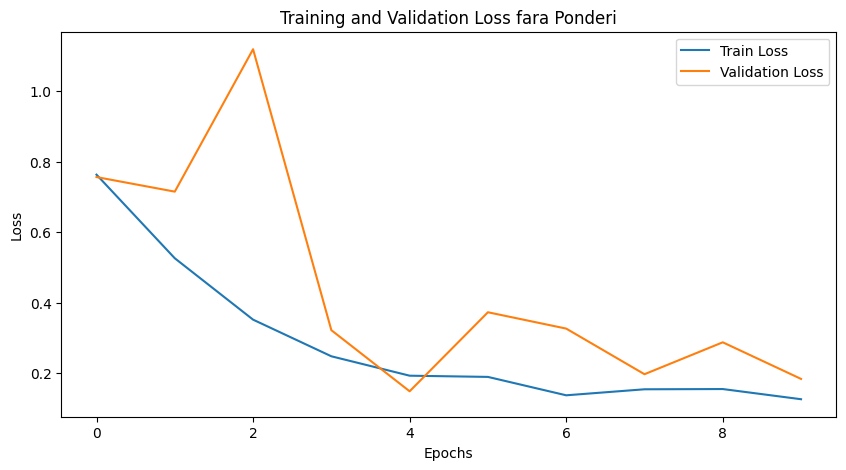

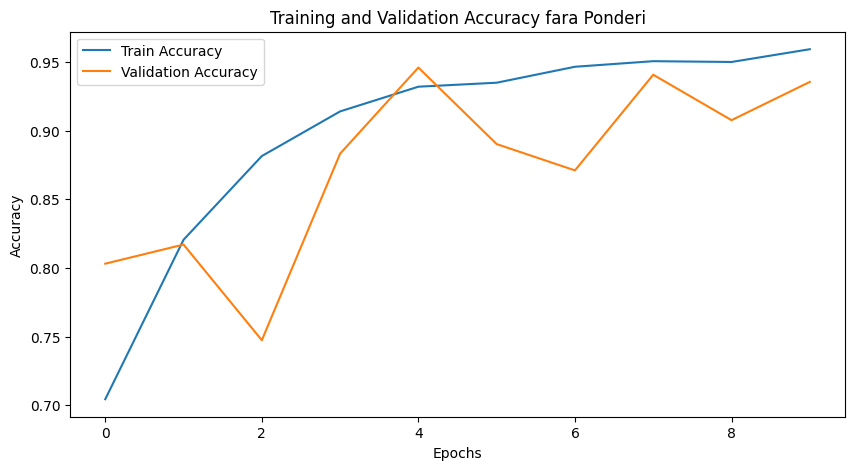

       Metrica  Cu Ponderi  Fara Ponderi
0  performance    0.894105      0.924757
1     accuracy    0.637056      0.753807
2    precision    0.680319      0.760245
3       recall    0.637056      0.753807
4     F1-score    0.584317      0.724167


In [ ]:
from collections import Counter

#Setul de date
train_x, train_y, val_x, val_y = get_splited_train_data()
test_x, test_y = get_test_data()

class_counts = Counter(train_y)

use_cuda = torch.cuda.is_available()
device = "cuda"

data = {
  "Metrica":["performance","accuracy", "precision", "recall", "F1-score"],
  "Cu Ponderi": [],
  "Fara Ponderi": []
}

# Loss cu ponderi
w0 = 1 / class_counts[0]
w1 = 1 / class_counts[1]
w2 = 1 / class_counts[2]
w3 = 1 / class_counts[3]

weights = torch.tensor([w0, w1, w2, w3], dtype=torch.float, device=device)

loss_function = nn.CrossEntropyLoss(weight = weights)

# Antrenare si testare  cu ponderi
test_performance, test_acc, test_precision, test_recall, test_f1, \
validation_acc_list, validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_model(
    train_x, train_y, val_x, val_y, test_x, test_y, loss_function, transforms_train, transforms_test
)

print(float(test_performance))
print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)

data["Cu Ponderi"] = [float(test_performance), test_acc, test_precision, test_recall, test_f1]

# Ploturi loss si acc pentru antrenare si validare cu Ponderi
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss cu Ponderi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy cu Ponderi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

loss_function = nn.CrossEntropyLoss()

# Antrenare si testare fara ponderi
test_performance, test_acc, test_precision, test_recall, test_f1, \
validation_acc_list, validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_model(
    train_x, train_y, val_x, val_y, test_x, test_y, loss_function, transforms_train, transforms_test
)

print(float(test_performance))
print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)

data["Fara Ponderi"] = [float(test_performance), test_acc, test_precision, test_recall, test_f1]

# Ploturi loss si acc pentru antrenare si validare fara Ponderi
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss fara Ponderi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy fara Ponderi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

df = pd.DataFrame(data)

print(df)


**Oversampling**

***Cu Augmentari***

In [ ]:
# !rm -r augmented_images/

In [ ]:
from collections import Counter

#Setul de date
train_x, train_y, val_x, val_y = get_splited_train_data()
test_x, test_y = get_test_data()



transform_aug = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
])

# Identificarea clasei majoritare
class_counts = Counter(train_y)
max_count = max(class_counts.values())

# Folder pentru salvarea augmentărilor
output_dir = "augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Generarea de exemple suplimentare pentru clasele minoritare
augmented_x = []
augmented_y = []

for cls, count in class_counts.items():
  if count < max_count:
    deficit = max_count - count

    # Selectarea exemplelor din clasa curentă
    class_indices = [i for i, label in enumerate(train_y) if label == cls]
    class_samples = [train_x[i] for i in class_indices]

    # Aplicarea augmentărilor pentru a genera exemple suplimentare
    for _ in range(deficit):
        sample_path = np.random.choice(class_samples)

        # Încărcarea imaginii
        image = Image.open(sample_path)

        # Aplicarea augmentării
        augmented_image = transform_aug(image)

        # Salvarea imaginii augmentate
        augmented_filename = os.path.join(output_dir, f"aug_cls{cls}_{_}.jpg")
        augmented_image.save(augmented_filename)

        # Adăugarea căii imaginii augmentate în lista de date
        augmented_x.append(augmented_filename)
        augmented_y.append(cls)

***Cu Duplicate***

In [ ]:
# Identificarea clasei majoritare
class_counts = Counter(train_y)
max_count = max(class_counts.values())

# Folder pentru salvarea augmentărilor
output_dir = "duplicated_images"
os.makedirs(output_dir, exist_ok=True)

# Generarea de exemple suplimentare pentru clasele minoritare
duplicated_x = []
duplicated_y = []

for cls, count in class_counts.items():
    if count < max_count:
        deficit = max_count - count

        # Selectarea exemplelor din clasa curentă
        class_indices = [i for i, label in enumerate(train_y) if label == cls]
        class_samples = [train_x[i] for i in class_indices]

        # Generarea suplimentară fără augmentări
        for _ in range(deficit):
            sample_path = np.random.choice(class_samples)

            # Încărcarea imaginii originale
            original_image = Image.open(sample_path)

            # Salvarea imaginii duplicate
            duplicated_filename = os.path.join(output_dir, f"dup_cls{cls}_{_}.jpg")
            original_image.save(duplicated_filename)

            # Adăugarea căii imaginii duplicate în lista de date
            duplicated_x.append(duplicated_filename)
            duplicated_y.append(cls)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/63, train_loss: 1.4407
2/63, train_loss: 1.3909
3/63, train_loss: 1.3366
4/63, train_loss: 1.3853
5/63, train_loss: 1.4007
6/63, train_loss: 1.3336
7/63, train_loss: 1.1291
8/63, train_loss: 0.9438
9/63, train_loss: 0.8736
10/63, train_loss: 0.7093
11/63, train_loss: 0.9015
12/63, train_loss: 0.8005
13/63, train_loss: 0.7986
14/63, train_loss: 0.5046
15/63, train_loss: 0.6249
16/63, train_loss: 0.4726
17/63, train_loss: 0.8135
18/63, train_loss: 0.8201
19/63, train_loss: 0.3997
20/63, train_loss: 0.6127
21/63, train_loss: 0.3518
22/63, train_loss: 0.5498
23/63, train_loss: 0.7490
24/63, train_loss: 1.0219
25/63, train_loss: 0.3599
26/63, train_loss: 0.6544
27/63, train_loss: 0.6300
28/63, train_loss: 0.5405
29/63, train_loss: 0.9601
30/63, train_loss: 0.5327
31/63, train_loss: 0.5355
32/63, train_loss: 0.7784
33/63, train_loss: 0.5457
34/63, train_loss: 0.5631
35/63, train_loss: 0.8270
36/63, train_loss: 0.3676
37/63, train_loss: 0.3590
38/63, train_loss: 0.4322

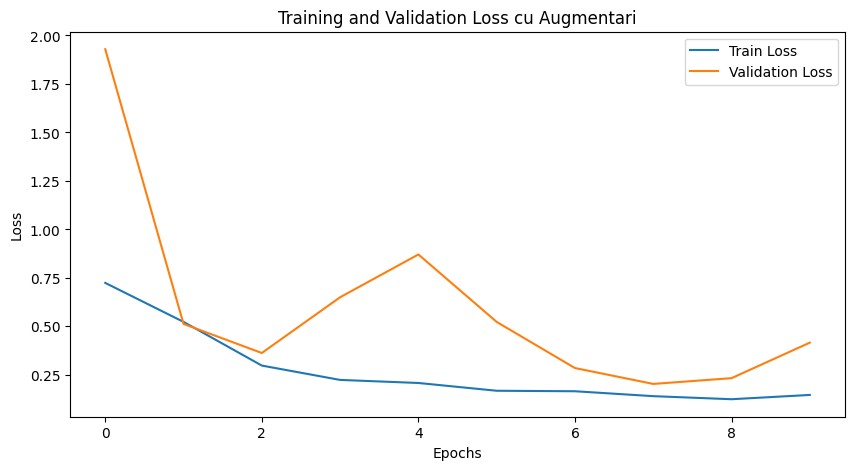

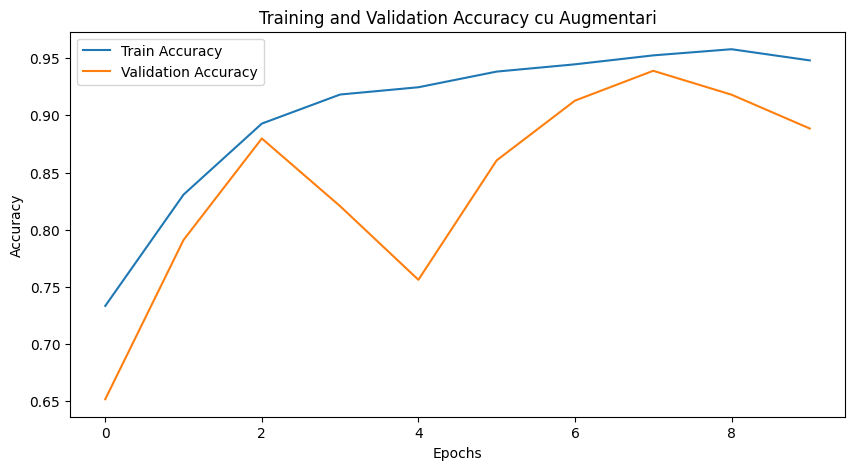

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/63, train_loss: 1.3790
2/63, train_loss: 1.5596
3/63, train_loss: 1.2622
4/63, train_loss: 1.7591
5/63, train_loss: 1.2856
6/63, train_loss: 1.2403
7/63, train_loss: 1.0897
8/63, train_loss: 0.7740
9/63, train_loss: 0.8935
10/63, train_loss: 0.9926
11/63, train_loss: 0.8550
12/63, train_loss: 1.5030
13/63, train_loss: 0.5600
14/63, train_loss: 0.9669
15/63, train_loss: 0.8042
16/63, train_loss: 0.3434
17/63, train_loss: 0.8774
18/63, train_loss: 1.0585
19/63, train_loss: 0.5036
20/63, train_loss: 0.4607
21/63, train_loss: 1.2929
22/63, train_loss: 1.2063
23/63, train_loss: 0.5305
24/63, train_loss: 0.2168
25/63, train_loss: 1.1016
26/63, train_loss: 0.1835
27/63, train_loss: 0.9155
28/63, train_loss: 0.3827
29/63, train_loss: 0.4568
30/63, train_loss: 0.9677
31/63, train_loss: 0.5990
32/63, train_loss: 1.0167
33/63, train_loss: 1.1545
34/63, train_loss: 0.7292
35/63, train_loss: 0.5458
36/63, train_loss: 1.0147
37/63, train_loss: 1.2109
38/63, train_loss: 1.2421

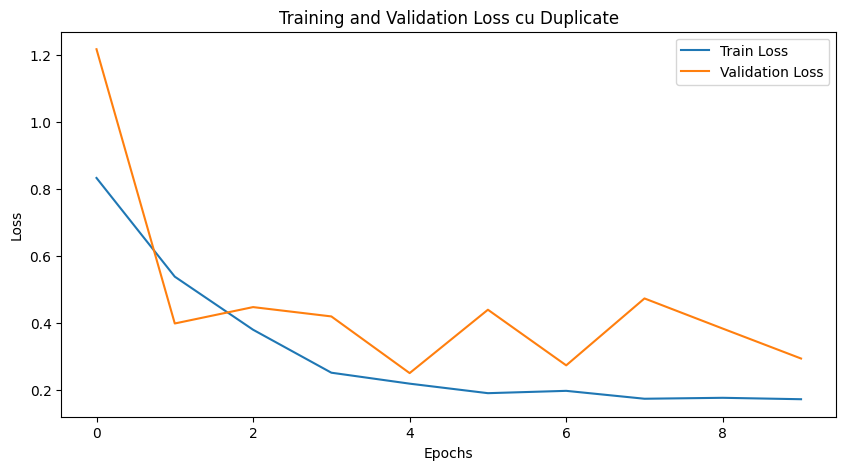

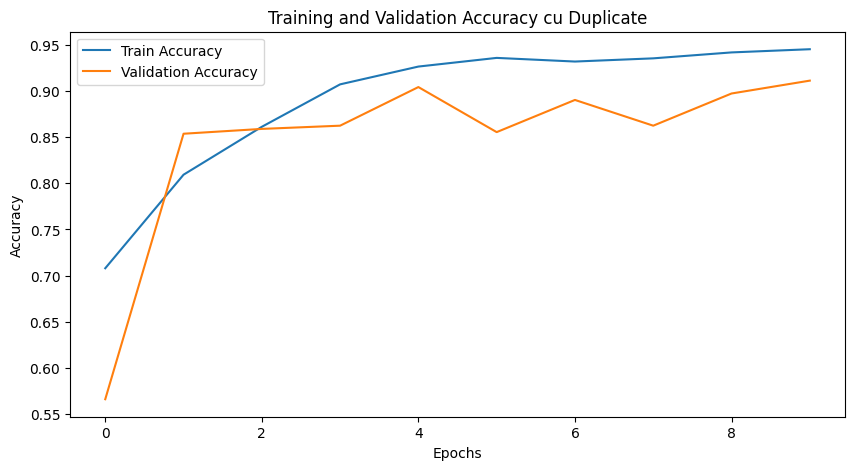

       Metrica  Cu Augmentari  Cu Duplicate
0  performance       0.897660      0.919470
1     accuracy       0.662437      0.730964
2    precision       0.740327      0.776587
3       recall       0.662437      0.730964
4     F1-score       0.640794      0.692194


In [ ]:
def get_image_and_label(data_dir):
  images_path = []
  labels = []
  for image in os.listdir(data_dir):
      start = image.find("cls") + 3
      end = image.find("_", start)
      clasa = image[start:end]

      image_path = os.path.join(data_dir, image)
      images_path.append(image_path)
      labels.append(int(clasa))

  return images_path, labels

data = {
  "Metrica":["performance","accuracy", "precision", "recall", "F1-score"],
  "Cu Augmentari": [],
  "Cu Duplicate": []
}

# Adăugarea exemplelor augmentate în setul original
augmented_x, augmented_y = get_image_and_label("augmented_images")

train_x_augmented = train_x + augmented_x
train_y_augmented = np.concatenate([train_y, np.array(augmented_y)])

loss_function = nn.CrossEntropyLoss()

# Antrenare si testare cu augmentari
test_performance, test_acc, test_precision, test_recall, test_f1, \
validation_acc_list, validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_model(
    train_x_augmented, train_y_augmented, val_x, val_y, test_x, test_y, loss_function, transforms_train, transforms_test
)

print(float(test_performance))
print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)

data["Cu Augmentari"] = [float(test_performance), test_acc, test_precision, test_recall, test_f1]

# Ploturi loss si acc pentru antrenare si validare cu Augmentari
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss cu Augmentari')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy cu Augmentari')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

duplicated_x, duplicated_y = get_image_and_label("duplicated_images")

# Adăugarea exemplelor augmentate și duplicate în setul original
train_x_duplicated = train_x + duplicated_x
train_y_duplicated = np.concatenate([train_y, np.array(duplicated_y)])

# Antrenare si testare cu duplicate
test_performance, test_acc, test_precision, test_recall, test_f1, \
validation_acc_list, validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list = train_model(
    train_x_duplicated, train_y_duplicated, val_x, val_y, test_x, test_y, loss_function, transforms_train, transforms_test
)

print(float(test_performance))
print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)

data["Cu Duplicate"] = [float(test_performance), test_acc, test_precision, test_recall, test_f1]

# Ploturi loss si acc pentru antrenare si validare cu Duplicate
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss cu Duplicate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy cu Duplicate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

df = pd.DataFrame(data)

print(df)


**Cerinta 3**

***Definirea augmentarilor***

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as F

class Transform_to_apply1:
  def __call__(self, image):

    image = resize_image(image)
    image = GaussianBlur(image)
    image = apply_clahe(image)

    image = Image.fromarray(image)

    return image

class Transform_to_apply2:
  def __call__(self, image):

    image = resize_image(image)
    image = GaussianBlur(image)
    image = apply_clahe(image)
    image = close_image(image)
    image = open_image(image)

    image = Image.fromarray(image)

    return image

def GaussianBlur(image_cv2):
  blurred_image = cv2.GaussianBlur(image_cv2, (5, 5), 1.0)
  return blurred_image

def apply_clahe(image_cv2):
  import albumentations as A

  cl = A.CLAHE(p=1)
  clahe = cl(image=image_cv2)["image"]

  return clahe

def resize_image(image_cv2):
   image_cv2 = cv2.resize(image_cv2, (224, 224))
   return image_cv2

def close_image(image_cv2, kernel_size = 3):
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  return cv2.morphologyEx(image_cv2, cv2.MORPH_CLOSE, kernel)

def open_image(image_cv2, kernel_size = 3):
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  return cv2.morphologyEx(image_cv2, cv2.MORPH_OPEN, kernel)

train_x, train_y, val_x, val_y = get_splited_train_data()
test_x, test_y = get_test_data()


# Stratified K-Fold
folds = stratified_k_fold_split(train_x + val_x, train_y + val_y, k=5)

dataset = {
    "Metrici" : ["Precision", "Recall", "F1-Score", "AUC"],
    "Set1": [],
    "Set2": [],
    "Set3": []
}

data_performance = {
    "Fold" : [1, 2, 3, 4, 5],
    "Set1": [],
    "Set2": [],
    "Set3": []
}



**# Transformari 1**

Training type 1 fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3688
2/57, train_loss: 1.4485
3/57, train_loss: 1.4996
4/57, train_loss: 1.2358
5/57, train_loss: 1.2442
6/57, train_loss: 1.0965
7/57, train_loss: 1.0530
8/57, train_loss: 0.7967
9/57, train_loss: 0.7740
10/57, train_loss: 0.6916
11/57, train_loss: 0.4995
12/57, train_loss: 0.4321
13/57, train_loss: 0.2342
14/57, train_loss: 1.1437
15/57, train_loss: 0.8757
16/57, train_loss: 0.1324
17/57, train_loss: 0.3720
18/57, train_loss: 0.7961
19/57, train_loss: 1.1966
20/57, train_loss: 0.5561
21/57, train_loss: 0.1582
22/57, train_loss: 0.5726
23/57, train_loss: 0.3350
24/57, train_loss: 0.5105
25/57, train_loss: 0.4449
26/57, train_loss: 0.6092
27/57, train_loss: 0.4301
28/57, train_loss: 0.5845
29/57, train_loss: 0.6309
30/57, train_loss: 0.5225
31/57, train_loss: 0.2724
32/57, train_loss: 0.5366
33/57, train_loss: 0.5660
34/57, train_loss: 0.2836
35/57, train_loss: 0.4600
36/57, train_loss: 0.8838
37/57, train_loss: 0.4233
38/57, train_loss: 0.8502

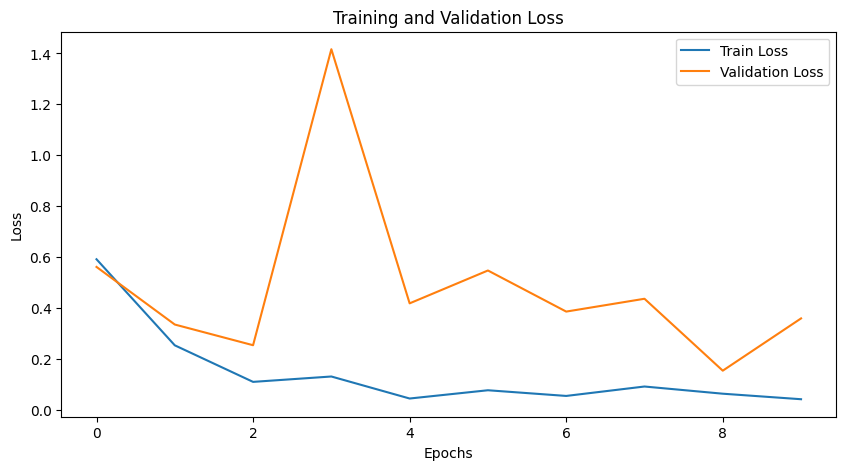

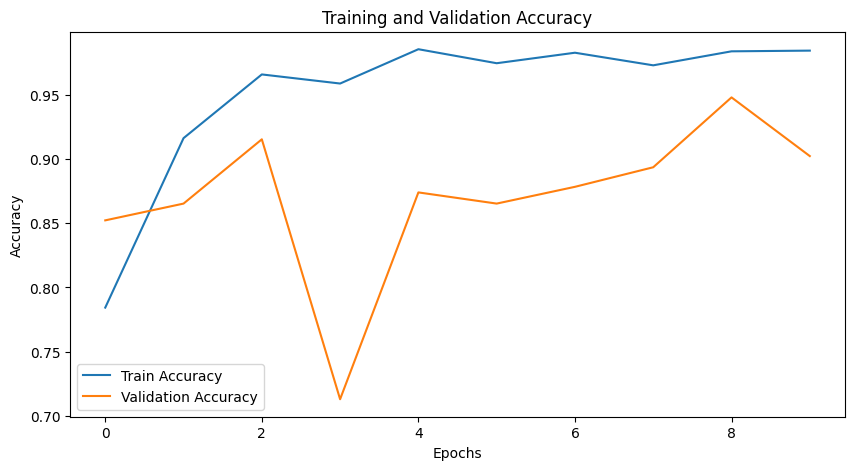

Training type 1 fold 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3550
2/57, train_loss: 1.3012
3/57, train_loss: 1.4126
4/57, train_loss: 1.1140
5/57, train_loss: 1.2511
6/57, train_loss: 1.0173
7/57, train_loss: 1.0681
8/57, train_loss: 1.3133
9/57, train_loss: 0.4730
10/57, train_loss: 0.5467
11/57, train_loss: 1.2202
12/57, train_loss: 1.1553
13/57, train_loss: 0.3369
14/57, train_loss: 0.4015
15/57, train_loss: 1.3657
16/57, train_loss: 0.3987
17/57, train_loss: 0.5498
18/57, train_loss: 0.8806
19/57, train_loss: 0.8076
20/57, train_loss: 0.3996
21/57, train_loss: 1.2599
22/57, train_loss: 0.8176
23/57, train_loss: 0.9944
24/57, train_loss: 0.9119
25/57, train_loss: 0.3384
26/57, train_loss: 0.4202
27/57, train_loss: 0.4382
28/57, train_loss: 0.5378
29/57, train_loss: 0.5867
30/57, train_loss: 0.6050
31/57, train_loss: 0.2669
32/57, train_loss: 0.6959
33/57, train_loss: 0.5550
34/57, train_loss: 0.4558
35/57, train_loss: 0.6007
36/57, train_loss: 0.0884
37/57, train_loss: 0.2035
38/57, train_loss: 0.4460

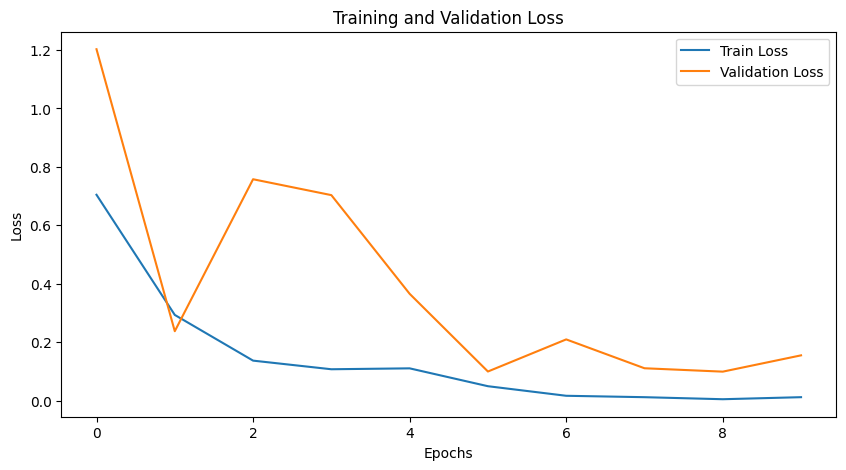

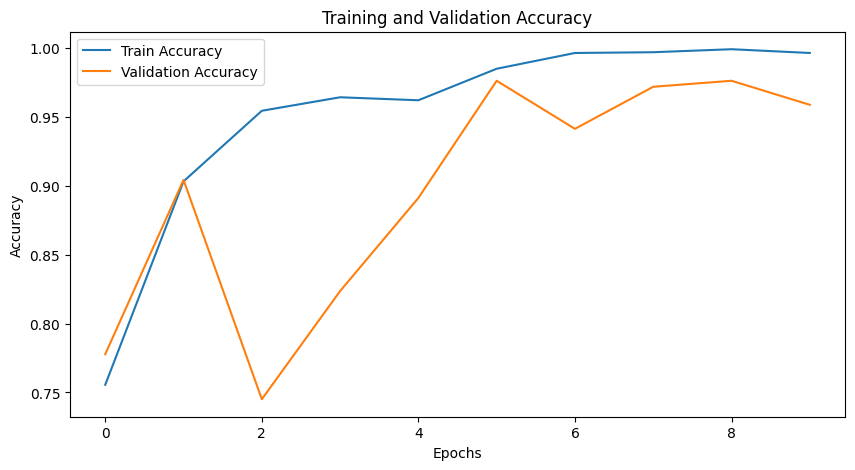

Training type 1 fold 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3719
2/57, train_loss: 1.4183
3/57, train_loss: 1.3734
4/57, train_loss: 1.3673
5/57, train_loss: 1.2794
6/57, train_loss: 1.5094
7/57, train_loss: 1.2236
8/57, train_loss: 0.8011
9/57, train_loss: 0.7284
10/57, train_loss: 0.5240
11/57, train_loss: 0.5815
12/57, train_loss: 0.4484
13/57, train_loss: 0.4774
14/57, train_loss: 0.6841
15/57, train_loss: 0.1601
16/57, train_loss: 0.8037
17/57, train_loss: 1.0830
18/57, train_loss: 0.4643
19/57, train_loss: 0.5582
20/57, train_loss: 0.3725
21/57, train_loss: 0.4387
22/57, train_loss: 0.3266
23/57, train_loss: 0.3792
24/57, train_loss: 0.7595
25/57, train_loss: 1.0944
26/57, train_loss: 1.1064
27/57, train_loss: 0.4714
28/57, train_loss: 1.0864
29/57, train_loss: 0.6107
30/57, train_loss: 0.9700
31/57, train_loss: 0.4068
32/57, train_loss: 0.5999
33/57, train_loss: 1.2254
34/57, train_loss: 0.7178
35/57, train_loss: 0.5744
36/57, train_loss: 0.3319
37/57, train_loss: 0.3787
38/57, train_loss: 0.5228

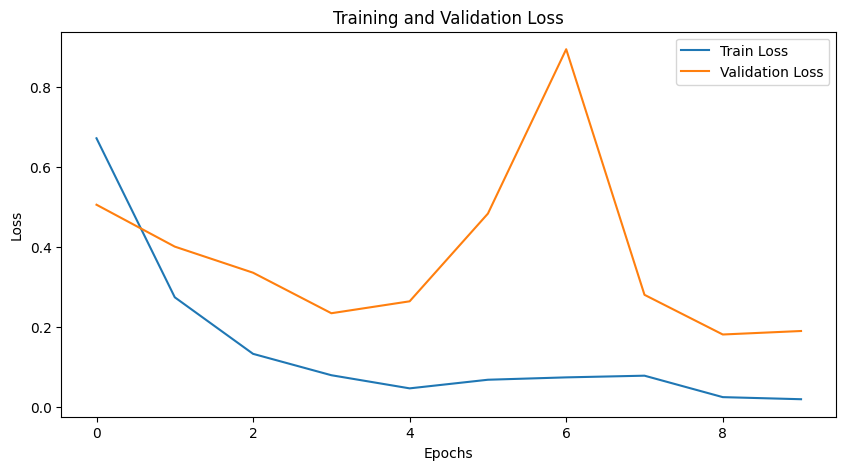

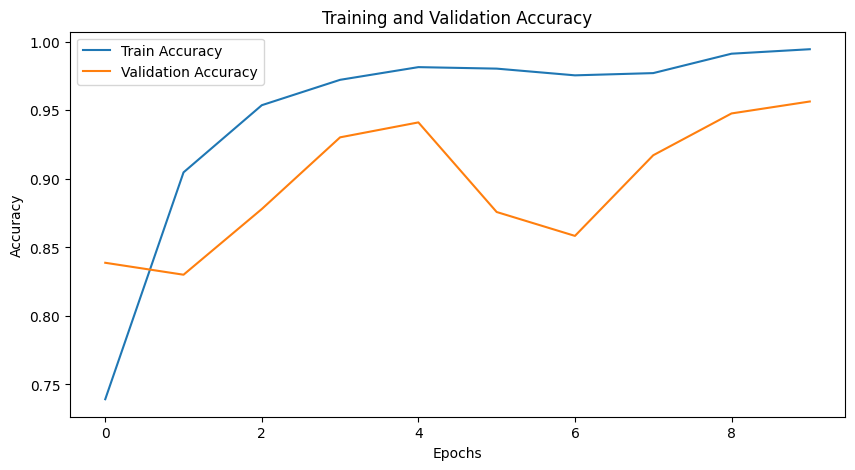

Training type 1 fold 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.4521
2/57, train_loss: 1.4200
3/57, train_loss: 1.3181
4/57, train_loss: 1.3162
5/57, train_loss: 1.2166
6/57, train_loss: 1.2388
7/57, train_loss: 1.0513
8/57, train_loss: 1.1894
9/57, train_loss: 0.7990
10/57, train_loss: 1.1018
11/57, train_loss: 0.5780
12/57, train_loss: 0.5982
13/57, train_loss: 0.6658
14/57, train_loss: 0.7142
15/57, train_loss: 0.5664
16/57, train_loss: 0.5421
17/57, train_loss: 0.3265
18/57, train_loss: 0.1350
19/57, train_loss: 0.5778
20/57, train_loss: 0.2323
21/57, train_loss: 0.5895
22/57, train_loss: 0.7447
23/57, train_loss: 0.5034
24/57, train_loss: 0.5337
25/57, train_loss: 0.2484
26/57, train_loss: 0.2153
27/57, train_loss: 0.3186
28/57, train_loss: 0.5386
29/57, train_loss: 0.3543
30/57, train_loss: 0.6769
31/57, train_loss: 0.4902
32/57, train_loss: 0.5598
33/57, train_loss: 0.9560
34/57, train_loss: 0.2084
35/57, train_loss: 0.3125
36/57, train_loss: 0.4095
37/57, train_loss: 0.6679
38/57, train_loss: 0.8179

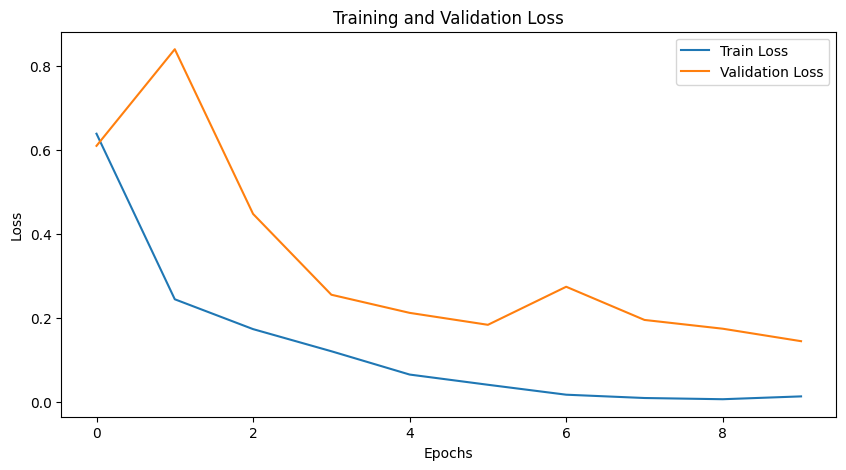

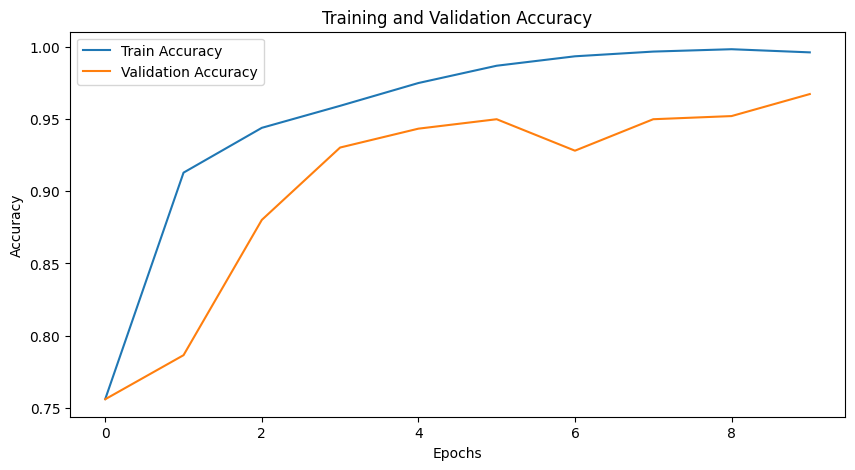

Training type 1 fold 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3044
2/57, train_loss: 1.5884
3/57, train_loss: 1.2479
4/57, train_loss: 1.8039
5/57, train_loss: 1.1046
6/57, train_loss: 1.1209
7/57, train_loss: 0.8672
8/57, train_loss: 0.6847
9/57, train_loss: 0.5887
10/57, train_loss: 0.4162
11/57, train_loss: 0.6315
12/57, train_loss: 0.6831
13/57, train_loss: 0.4803
14/57, train_loss: 0.5136
15/57, train_loss: 0.7558
16/57, train_loss: 0.6088
17/57, train_loss: 0.5179
18/57, train_loss: 0.5572
19/57, train_loss: 0.4666
20/57, train_loss: 0.6568
21/57, train_loss: 0.2916
22/57, train_loss: 0.6561
23/57, train_loss: 0.2042
24/57, train_loss: 0.4055
25/57, train_loss: 0.5851
26/57, train_loss: 0.2541
27/57, train_loss: 0.2634
28/57, train_loss: 0.8248
29/57, train_loss: 0.5710
30/57, train_loss: 0.4561
31/57, train_loss: 0.8480
32/57, train_loss: 1.2109
33/57, train_loss: 1.3192
34/57, train_loss: 0.6514
35/57, train_loss: 0.4649
36/57, train_loss: 0.3630
37/57, train_loss: 0.8609
38/57, train_loss: 0.9451

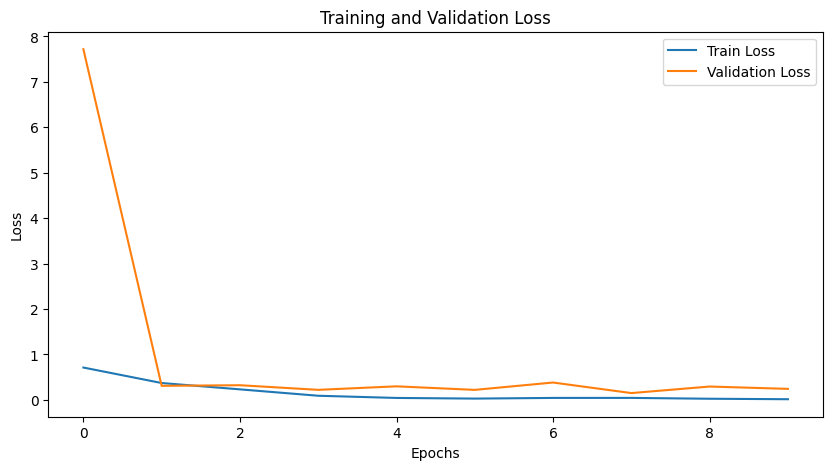

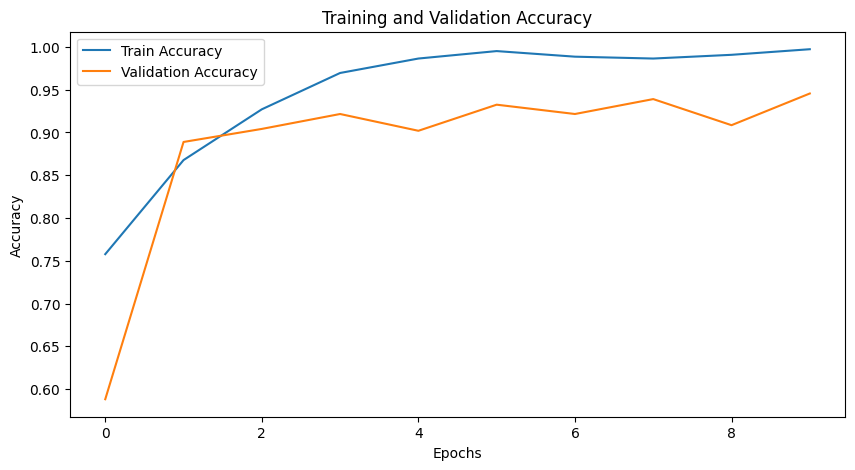

In [ ]:

transforms_train1 = transforms.Compose([
    Transform_to_apply1(),
    transforms.ToTensor()
])

all_test_acc_1 = []
all_test_precision_1 = []
all_test_recall_1 = []
all_test_f1_1 = []
all_test_auc_1 = []

all_validation_acc_1 = {}
all_validation_precision_1 ={}
all_validation_recall_1 = {}
all_validation_f1_1={}

for fold_num, (train_index, val_index) in enumerate(folds):
  print(f"Training type 1 fold {fold_num + 1}")
  # Creăm seturile de antrenare și validare pentru acest fold

  all_x = train_x + val_x
  all_y = train_y + val_y
  fold_train_x = [all_x[i] for i in train_index]
  fold_train_y = [all_y[i] for i in train_index]
  fold_val_x = [all_x[i] for i in val_index]
  fold_val_y = [all_y[i] for i in val_index]

  test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, \
  validation_precision_list, validation_recall_list, validation_f1_list, \
  train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list= train_model(
      fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, nn.CrossEntropyLoss(), transforms_train1, transforms_train1
      )

  all_test_auc_1.append(test_performance)
  all_test_acc_1.append(test_acc)
  all_test_precision_1.append(test_precision)
  all_test_recall_1.append(test_recall)
  all_test_f1_1.append(test_f1)
  all_validation_acc_1[fold_num + 1] = validation_acc_list
  all_validation_precision_1[fold_num + 1] = validation_precision_list
  all_validation_recall_1[fold_num + 1]= validation_recall_list
  all_validation_f1_1[fold_num + 1] = validation_f1_list

  # Ploturi loss si acc pentru antrenare si validare
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss_list, label='Train Loss')
  plt.plot(validation_loss_list, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('training_validation_loss_train1_' + str(fold_num + 1) +'.png')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracy_list, label='Train Accuracy')
  plt.plot(validation_accuracy_list, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('training_validation_accuracy_train1_' + str(fold_num + 1) +'.png')
  plt.show()


**Valori medii set 1**

In [ ]:
# Preluate de la rulare si salvate in cazul deconectarii

all_test_acc_1 = [0.799492385786802, 0.7588832487309645, 0.733502538071066, 0.7284263959390863, 0.7157360406091371]

all_test_precision_1 = [0.820125154072127, 0.8171229629505462, 0.794457502938161, 0.7925214315132643, 0.7833803272534117]

all_test_recall_1 = [0.799492385786802, 0.7588832487309645, 0.733502538071066, 0.7284263959390863, 0.7157360406091371]

all_test_f1_1 = [0.7776987274393011, 0.73215979376099, 0.6933838233032023, 0.6857137301152598, 0.684995414454678]

all_test_auc_1 = [0.935730516910553, 0.9322068691253662, 0.9466570615768433, 0.9346755743026733, 0.926912784576416]
all_test_auc_1 = [float(x) for x in all_test_auc_1]

In [ ]:
import statistics
train1_auc_mean = statistics.mean(all_test_auc_1)
train1_acc_mean = statistics.mean(all_test_acc_1)
train1_precision_mean = statistics.mean(all_test_precision_1)
train1_recall_mean = statistics.mean(all_test_recall_1)
train1_f1_mean = statistics.mean(all_test_f1_1)

print(all_test_auc_1)
print(all_test_acc_1)
print(all_test_precision_1)
print(all_test_recall_1)
print(all_test_f1_1)

train1_means = [train1_precision_mean, train1_recall_mean, train1_f1_mean, train1_auc_mean]
dataset["Set1"] = train1_means
data_performance["Set1"] = all_test_auc_1


[0.935730516910553, 0.9322068691253662, 0.9466570615768433, 0.9346755743026733, 0.926912784576416]
[0.799492385786802, 0.7588832487309645, 0.733502538071066, 0.7284263959390863, 0.7157360406091371]
[0.820125154072127, 0.8171229629505462, 0.794457502938161, 0.7925214315132643, 0.7833803272534117]
[0.799492385786802, 0.7588832487309645, 0.733502538071066, 0.7284263959390863, 0.7157360406091371]
[0.7776987274393011, 0.73215979376099, 0.6933838233032023, 0.6857137301152598, 0.684995414454678]


**# Transformari 2**

Training type 2 fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3110
2/57, train_loss: 1.3888
3/57, train_loss: 1.4787
4/57, train_loss: 1.2619
5/57, train_loss: 1.4000
6/57, train_loss: 1.0951
7/57, train_loss: 1.0131
8/57, train_loss: 1.0447
9/57, train_loss: 1.1627
10/57, train_loss: 0.9167
11/57, train_loss: 0.8154
12/57, train_loss: 0.6202
13/57, train_loss: 0.3958
14/57, train_loss: 0.8415
15/57, train_loss: 0.4839
16/57, train_loss: 0.5092
17/57, train_loss: 0.7278
18/57, train_loss: 0.4671
19/57, train_loss: 0.6094
20/57, train_loss: 1.1858
21/57, train_loss: 0.2600
22/57, train_loss: 0.8129
23/57, train_loss: 0.7397
24/57, train_loss: 0.8384
25/57, train_loss: 0.5796
26/57, train_loss: 0.3509
27/57, train_loss: 0.8237
28/57, train_loss: 0.3242
29/57, train_loss: 0.5196
30/57, train_loss: 0.9070
31/57, train_loss: 0.7427
32/57, train_loss: 0.9747
33/57, train_loss: 0.7024
34/57, train_loss: 0.3859
35/57, train_loss: 0.9011
36/57, train_loss: 0.7500
37/57, train_loss: 0.6522
38/57, train_loss: 1.9985

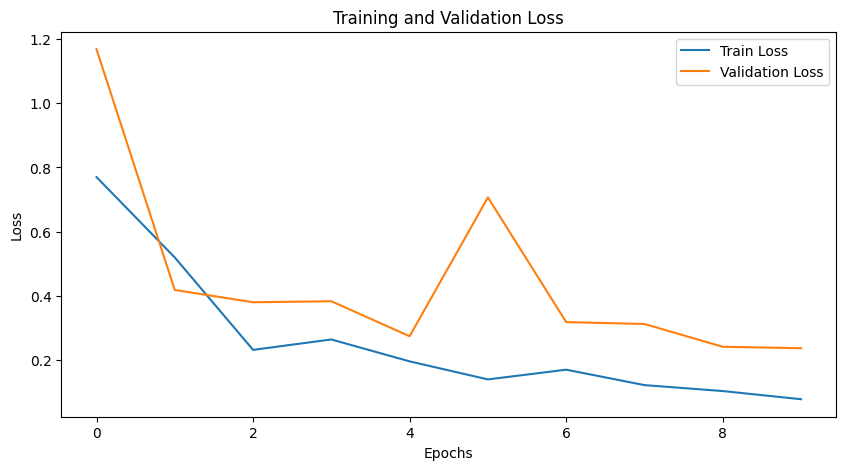

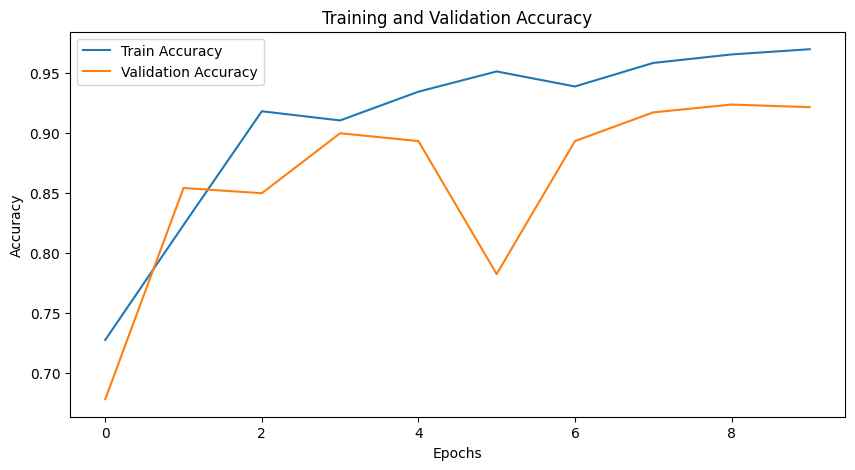

Training type 2 fold 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3426
2/57, train_loss: 1.4035
3/57, train_loss: 1.3089
4/57, train_loss: 1.4193
5/57, train_loss: 1.0654
6/57, train_loss: 1.2194
7/57, train_loss: 1.1194
8/57, train_loss: 1.0167
9/57, train_loss: 0.9494
10/57, train_loss: 1.2970
11/57, train_loss: 0.6223
12/57, train_loss: 0.8598
13/57, train_loss: 0.6816
14/57, train_loss: 1.0717
15/57, train_loss: 0.9319
16/57, train_loss: 1.2063
17/57, train_loss: 0.6992
18/57, train_loss: 0.7917
19/57, train_loss: 1.2721
20/57, train_loss: 0.4104
21/57, train_loss: 0.3517
22/57, train_loss: 0.8870
23/57, train_loss: 0.4844
24/57, train_loss: 0.8003
25/57, train_loss: 1.5026
26/57, train_loss: 0.6639
27/57, train_loss: 0.6441
28/57, train_loss: 1.0638
29/57, train_loss: 0.8279
30/57, train_loss: 0.4513
31/57, train_loss: 0.3448
32/57, train_loss: 0.5802
33/57, train_loss: 0.4077
34/57, train_loss: 0.3755
35/57, train_loss: 0.6930
36/57, train_loss: 0.4070
37/57, train_loss: 0.7683
38/57, train_loss: 1.3715

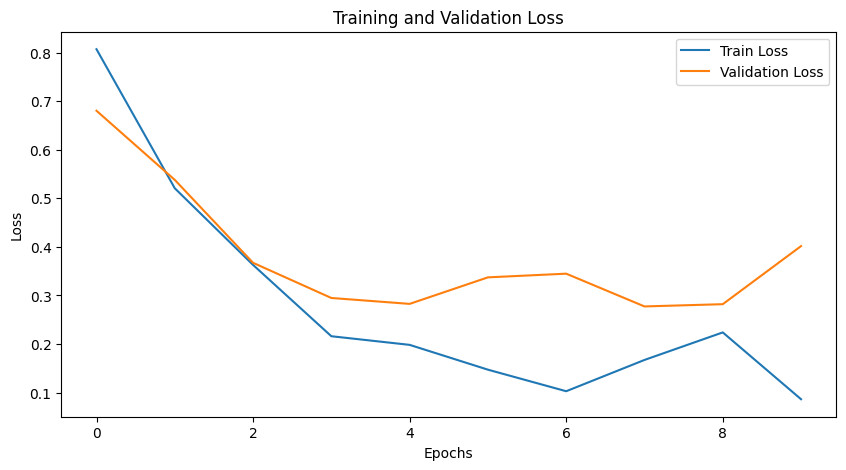

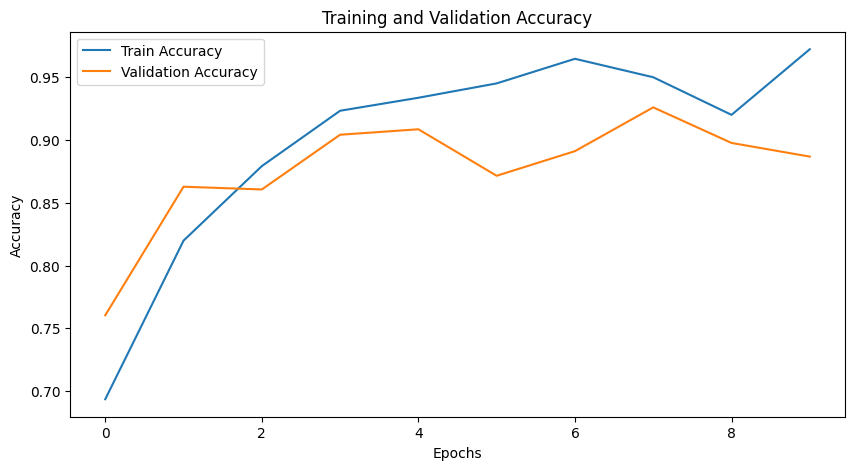

Training type 2 fold 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3292
2/57, train_loss: 1.2643
3/57, train_loss: 1.2614
4/57, train_loss: 1.2290
5/57, train_loss: 1.3720
6/57, train_loss: 1.3045
7/57, train_loss: 0.9375
8/57, train_loss: 0.8930
9/57, train_loss: 1.3103
10/57, train_loss: 0.8978
11/57, train_loss: 0.6948
12/57, train_loss: 0.6338
13/57, train_loss: 0.3833
14/57, train_loss: 0.7375
15/57, train_loss: 0.9216
16/57, train_loss: 0.6837
17/57, train_loss: 0.8236
18/57, train_loss: 0.7020
19/57, train_loss: 0.8735
20/57, train_loss: 0.2724
21/57, train_loss: 0.8873
22/57, train_loss: 0.7473
23/57, train_loss: 0.4760
24/57, train_loss: 0.9304
25/57, train_loss: 0.7725
26/57, train_loss: 1.3659
27/57, train_loss: 0.4374
28/57, train_loss: 0.9446
29/57, train_loss: 0.7664
30/57, train_loss: 0.6976
31/57, train_loss: 0.9526
32/57, train_loss: 1.0834
33/57, train_loss: 0.7929
34/57, train_loss: 0.6535
35/57, train_loss: 0.9067
36/57, train_loss: 0.4972
37/57, train_loss: 0.8842
38/57, train_loss: 0.4654

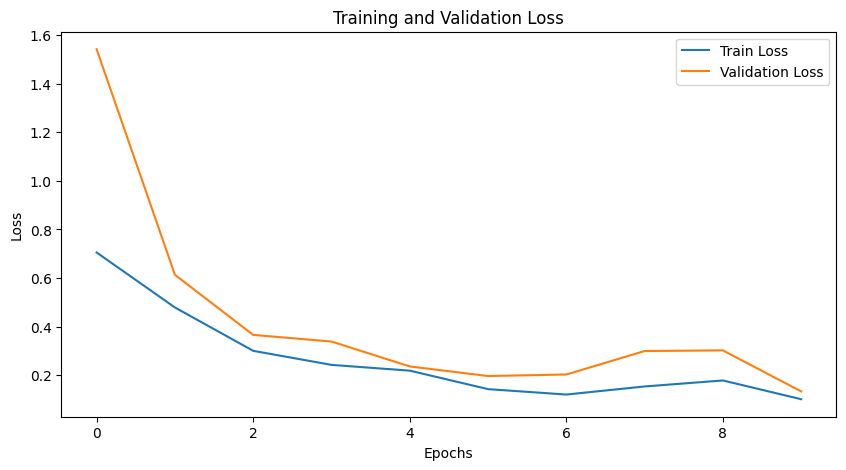

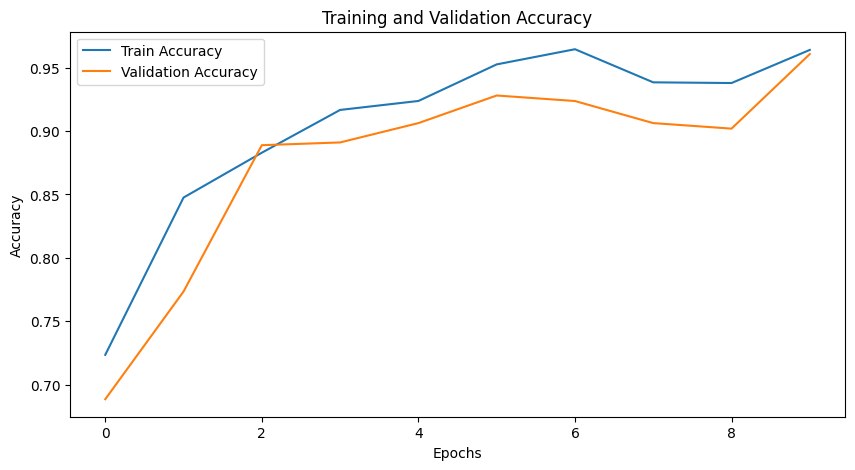

Training type 2 fold 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3622
2/57, train_loss: 1.7004
3/57, train_loss: 1.3742
4/57, train_loss: 1.2693
5/57, train_loss: 1.2038
6/57, train_loss: 1.1122
7/57, train_loss: 1.4777
8/57, train_loss: 0.9826
9/57, train_loss: 0.8578
10/57, train_loss: 1.0982
11/57, train_loss: 1.2858
12/57, train_loss: 1.5710
13/57, train_loss: 0.6816
14/57, train_loss: 0.4505
15/57, train_loss: 0.7792
16/57, train_loss: 1.3070
17/57, train_loss: 1.0181
18/57, train_loss: 0.8479
19/57, train_loss: 0.7482
20/57, train_loss: 0.9366
21/57, train_loss: 1.3253
22/57, train_loss: 0.8017
23/57, train_loss: 0.9423
24/57, train_loss: 1.0020
25/57, train_loss: 0.4994
26/57, train_loss: 0.5320
27/57, train_loss: 0.5065
28/57, train_loss: 0.8875
29/57, train_loss: 0.7620
30/57, train_loss: 0.7259
31/57, train_loss: 1.0492
32/57, train_loss: 0.8478
33/57, train_loss: 1.0117
34/57, train_loss: 0.6734
35/57, train_loss: 0.3242
36/57, train_loss: 0.3258
37/57, train_loss: 0.5974
38/57, train_loss: 1.0362

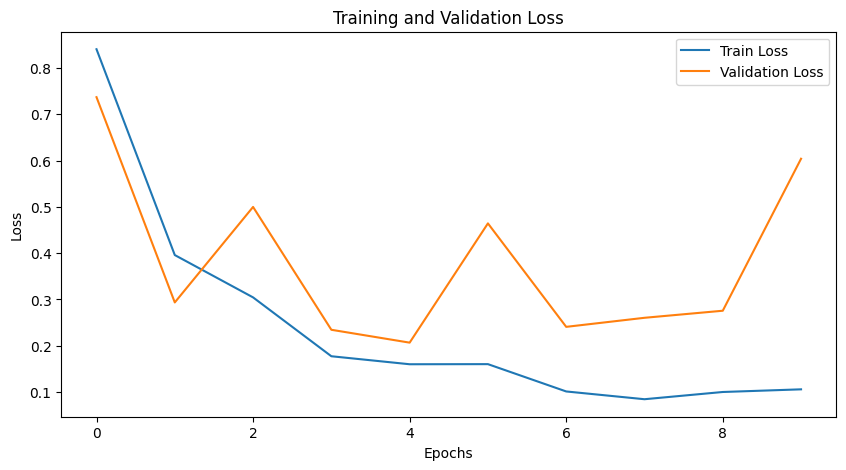

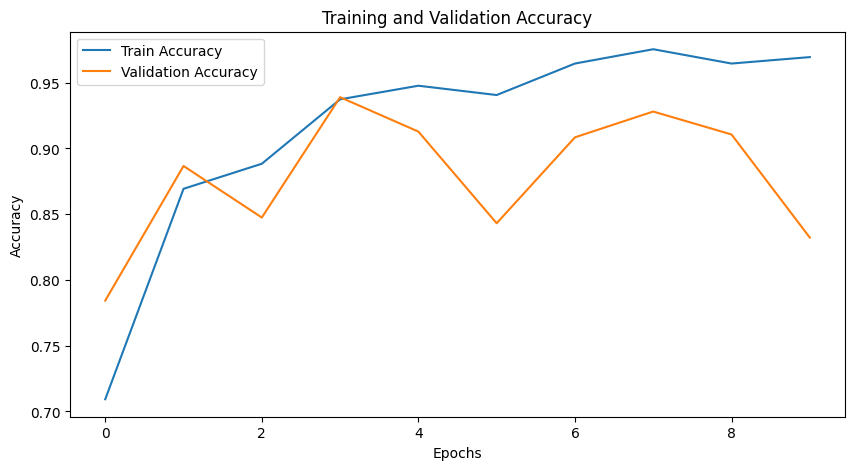

Training type 2 fold 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.4194
2/57, train_loss: 1.6292
3/57, train_loss: 1.4897
4/57, train_loss: 1.2543
5/57, train_loss: 2.2446
6/57, train_loss: 1.2571
7/57, train_loss: 1.8761
8/57, train_loss: 1.1294
9/57, train_loss: 0.8985
10/57, train_loss: 1.0456
11/57, train_loss: 0.7655
12/57, train_loss: 0.6439
13/57, train_loss: 0.3756
14/57, train_loss: 0.4604
15/57, train_loss: 0.3256
16/57, train_loss: 0.7601
17/57, train_loss: 0.6774
18/57, train_loss: 0.6840
19/57, train_loss: 0.4636
20/57, train_loss: 0.8900
21/57, train_loss: 0.6501
22/57, train_loss: 1.0646
23/57, train_loss: 0.2207
24/57, train_loss: 1.2279
25/57, train_loss: 0.7178
26/57, train_loss: 1.4133
27/57, train_loss: 0.4759
28/57, train_loss: 0.4596
29/57, train_loss: 1.1376
30/57, train_loss: 0.7844
31/57, train_loss: 0.7606
32/57, train_loss: 0.5642
33/57, train_loss: 0.3684
34/57, train_loss: 0.6611
35/57, train_loss: 0.3739
36/57, train_loss: 0.7734
37/57, train_loss: 0.5745
38/57, train_loss: 0.3704

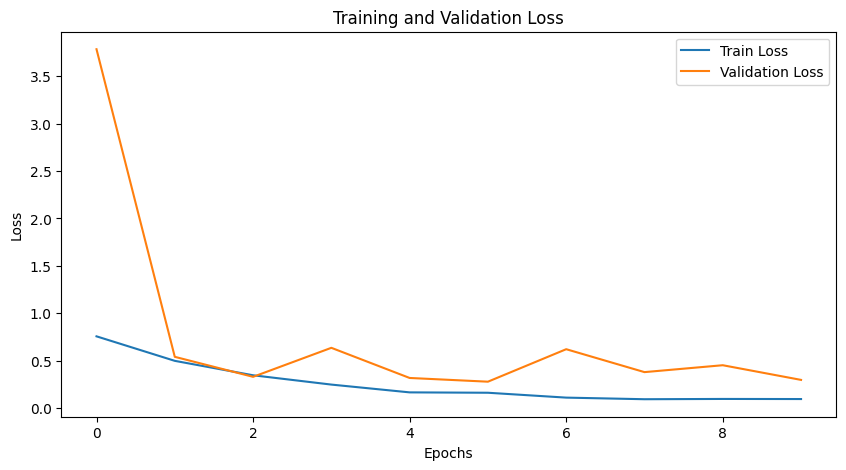

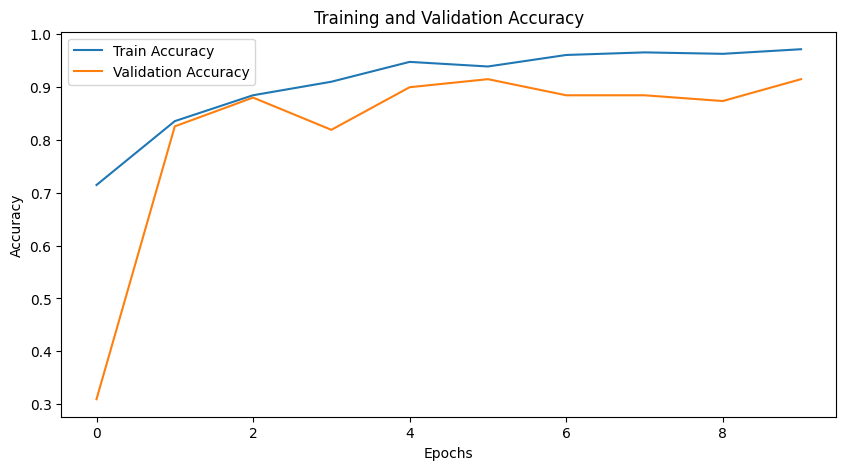

In [ ]:
transforms_train2 = transforms.Compose([
    Transform_to_apply1(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

transforms_test2 = transforms.Compose([
    Transform_to_apply1(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

all_test_acc_2 = []
all_test_precision_2 = []
all_test_recall_2 = []
all_test_f1_2 = []
all_test_auc_2 = []

all_validation_acc_2 = {}
all_validation_precision_2 ={}
all_validation_recall_2 = {}
all_validation_f1_2 = {}

for fold_num, (train_index, val_index) in enumerate(folds):
  print(f"Training type 2 fold {fold_num + 1}")
  # Creăm seturile de antrenare și validare pentru acest fold

  all_x = train_x + val_x
  all_y = train_y + val_y
  fold_train_x = [all_x[i] for i in train_index]
  fold_train_y = [all_y[i] for i in train_index]
  fold_val_x = [all_x[i] for i in val_index]
  fold_val_y = [all_y[i] for i in val_index]

  test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, \
  validation_precision_list, validation_recall_list, validation_f1_list, \
  train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list= train_model(
      fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, nn.CrossEntropyLoss(), transforms_train2, transforms_test2
      )

  all_test_auc_2.append(test_performance)
  all_test_acc_2.append(test_acc)
  all_test_precision_2.append(test_precision)
  all_test_recall_2.append(test_recall)
  all_test_f1_2.append(test_f1)
  all_validation_acc_2[fold_num + 1] = validation_acc_list
  all_validation_precision_2[fold_num + 1] = validation_precision_list
  all_validation_recall_2[fold_num + 1]= validation_recall_list
  all_validation_f1_2[fold_num + 1] = validation_f1_list

  # Ploturi loss si acc pentru antrenare si validare
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss_list, label='Train Loss')
  plt.plot(validation_loss_list, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('training_validation_loss_train2_' + str(fold_num + 1) +'.png')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracy_list, label='Train Accuracy')
  plt.plot(validation_accuracy_list, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('training_validation_accuracy_train2_' + str(fold_num + 1) +'.png')
  plt.show()



**Valori medii set 2**

In [ ]:
# Preluate de la rulare si salvate in cazul deconectarii

all_test_auc_2 = [0.9267093539237976, 0.9148873090744019, 0.9055231213569641, 0.8999854922294617, 0.9032580852508545]
all_test_acc_2 = [0.7385786802030457, 0.7411167512690355, 0.6979695431472082, 0.682741116751269, 0.700507614213198]
all_test_precision_2 = [0.7852987343225667, 0.773585382540378, 0.7839421025527846, 0.758527989911798, 0.7680501411760459]
all_test_recall_2 = [0.7385786802030457, 0.7411167512690355, 0.6979695431472082, 0.682741116751269, 0.700507614213198]
all_test_f1_2 = [0.6978482528310892, 0.7188236706063047, 0.6595816166210441, 0.6209047329944395, 0.6479382210879244]

In [ ]:
import statistics
all_test_auc_2 = [float(x) for x in all_test_auc_2]
train2_auc_mean = statistics.mean(all_test_auc_2)
train2_acc_mean = statistics.mean(all_test_acc_2)
train2_precision_mean = statistics.mean(all_test_precision_2)
train2_recall_mean = statistics.mean(all_test_recall_2)
train2_f1_mean = statistics.mean(all_test_f1_2)

train2_means = [train2_precision_mean, train2_recall_mean, train2_f1_mean, train2_auc_mean]
dataset["Set2"] = train2_means
data_performance["Set2"] = all_test_auc_2

print(all_test_auc_2)
print(all_test_acc_2)
print(all_test_precision_2)
print(all_test_recall_2)
print(all_test_f1_2)


[0.9267093539237976, 0.9148873090744019, 0.9055231213569641, 0.8999854922294617, 0.9032580852508545]
[0.7385786802030457, 0.7411167512690355, 0.6979695431472082, 0.682741116751269, 0.700507614213198]
[0.7852987343225667, 0.773585382540378, 0.7839421025527846, 0.758527989911798, 0.7680501411760459]
[0.7385786802030457, 0.7411167512690355, 0.6979695431472082, 0.682741116751269, 0.700507614213198]
[0.6978482528310892, 0.7188236706063047, 0.6595816166210441, 0.6209047329944395, 0.6479382210879244]


**# Transformari 3**

Training type 3 fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.2785
2/57, train_loss: 1.4011
3/57, train_loss: 1.5145
4/57, train_loss: 1.3609
5/57, train_loss: 1.3187
6/57, train_loss: 1.2477
7/57, train_loss: 1.1430
8/57, train_loss: 1.1154
9/57, train_loss: 1.1934
10/57, train_loss: 1.1489
11/57, train_loss: 1.0886
12/57, train_loss: 0.6934
13/57, train_loss: 0.5082
14/57, train_loss: 0.8941
15/57, train_loss: 0.6096
16/57, train_loss: 0.6564
17/57, train_loss: 0.9131
18/57, train_loss: 0.6929
19/57, train_loss: 0.4172
20/57, train_loss: 1.6660
21/57, train_loss: 0.2757
22/57, train_loss: 0.8285
23/57, train_loss: 1.0966
24/57, train_loss: 1.2253
25/57, train_loss: 0.5351
26/57, train_loss: 0.4503
27/57, train_loss: 0.9766
28/57, train_loss: 0.5065
29/57, train_loss: 1.0586
30/57, train_loss: 1.2455
31/57, train_loss: 0.9471
32/57, train_loss: 1.2322
33/57, train_loss: 0.7611
34/57, train_loss: 0.9189
35/57, train_loss: 1.2588
36/57, train_loss: 0.9011
37/57, train_loss: 0.9456
38/57, train_loss: 1.1719

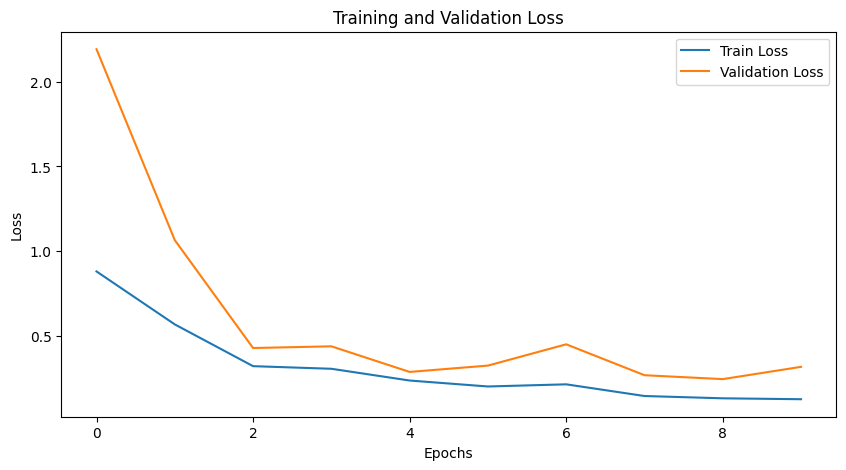

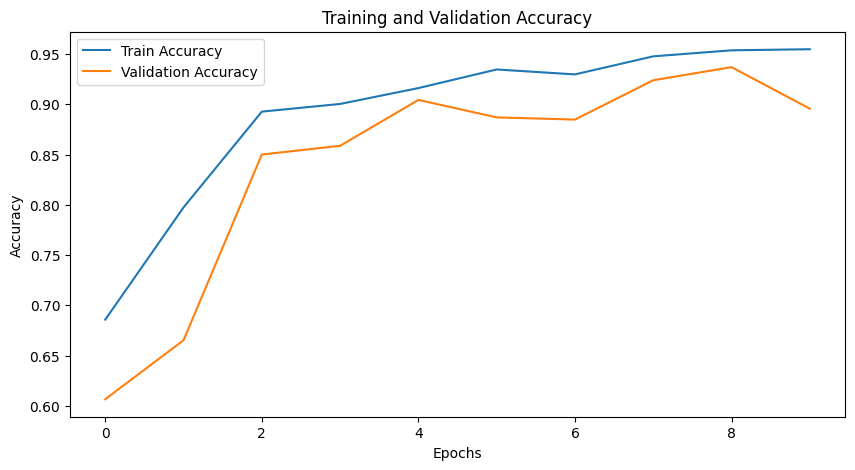

Training type 3 fold 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3665
2/57, train_loss: 1.4269
3/57, train_loss: 1.3328
4/57, train_loss: 1.4232
5/57, train_loss: 1.1129
6/57, train_loss: 1.3297
7/57, train_loss: 1.2159
8/57, train_loss: 1.0780
9/57, train_loss: 0.8623
10/57, train_loss: 1.3438
11/57, train_loss: 0.9404
12/57, train_loss: 0.9294
13/57, train_loss: 0.9366
14/57, train_loss: 0.8819
15/57, train_loss: 0.9242
16/57, train_loss: 1.1184
17/57, train_loss: 0.8832
18/57, train_loss: 0.8932
19/57, train_loss: 0.8656
20/57, train_loss: 1.0650
21/57, train_loss: 0.4377
22/57, train_loss: 0.9501
23/57, train_loss: 0.5528
24/57, train_loss: 0.8237
25/57, train_loss: 1.0590
26/57, train_loss: 0.9110
27/57, train_loss: 0.8449
28/57, train_loss: 0.9575
29/57, train_loss: 0.8143
30/57, train_loss: 0.6563
31/57, train_loss: 0.8729
32/57, train_loss: 0.6441
33/57, train_loss: 0.4000
34/57, train_loss: 0.3010
35/57, train_loss: 0.6462
36/57, train_loss: 0.5416
37/57, train_loss: 0.6072
38/57, train_loss: 0.9118

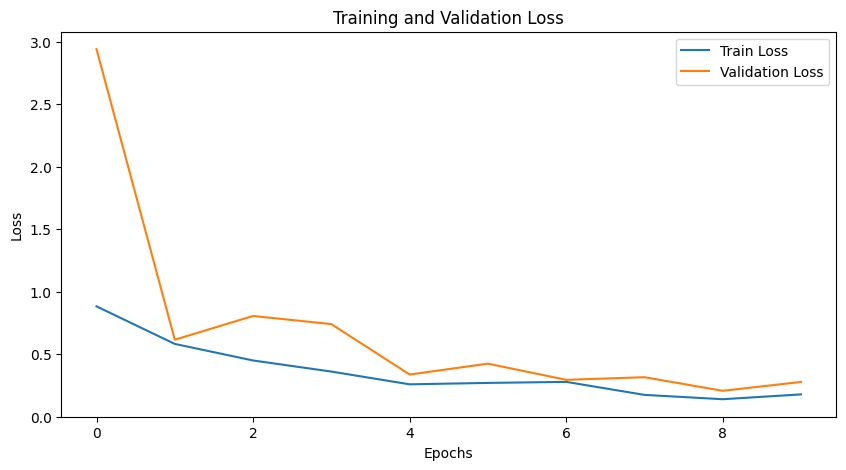

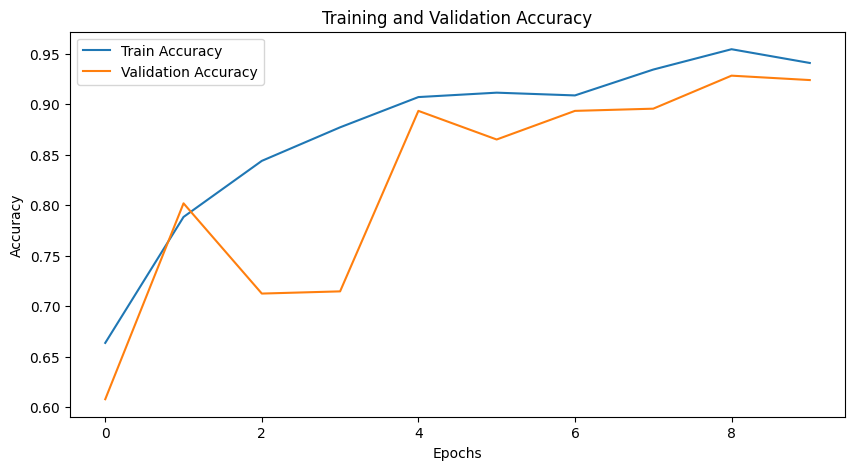

Training type 3 fold 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3442
2/57, train_loss: 1.2710
3/57, train_loss: 1.2526
4/57, train_loss: 1.2674
5/57, train_loss: 1.5158
6/57, train_loss: 1.2822
7/57, train_loss: 1.0848
8/57, train_loss: 1.0834
9/57, train_loss: 1.2185
10/57, train_loss: 1.0371
11/57, train_loss: 0.9364
12/57, train_loss: 0.7827
13/57, train_loss: 0.4959
14/57, train_loss: 0.7479
15/57, train_loss: 1.2394
16/57, train_loss: 0.6738
17/57, train_loss: 0.9010
18/57, train_loss: 0.8045
19/57, train_loss: 1.0609
20/57, train_loss: 0.5510
21/57, train_loss: 0.7477
22/57, train_loss: 1.1392
23/57, train_loss: 0.6824
24/57, train_loss: 1.4160
25/57, train_loss: 1.0712
26/57, train_loss: 1.0695
27/57, train_loss: 0.2805
28/57, train_loss: 0.9464
29/57, train_loss: 0.5417
30/57, train_loss: 0.5116
31/57, train_loss: 0.4344
32/57, train_loss: 0.9158
33/57, train_loss: 0.5541
34/57, train_loss: 0.5455
35/57, train_loss: 0.5062
36/57, train_loss: 0.4784
37/57, train_loss: 1.6069
38/57, train_loss: 0.7258

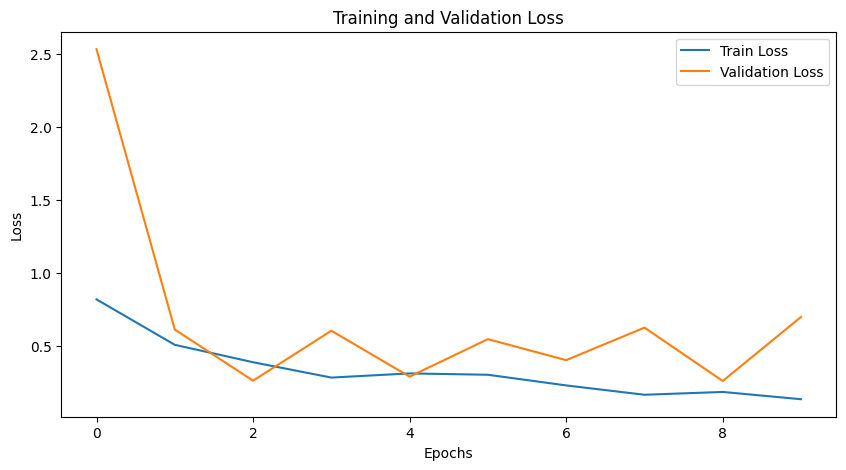

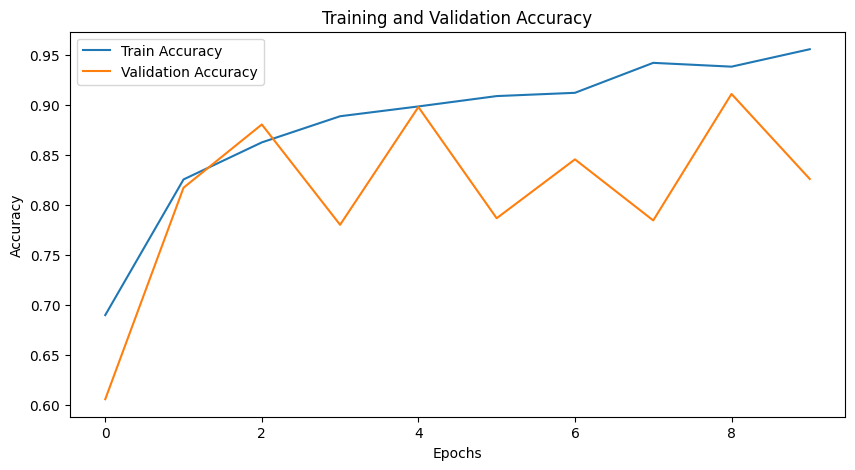

Training type 3 fold 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3683
2/57, train_loss: 1.7076
3/57, train_loss: 1.3161
4/57, train_loss: 1.2335
5/57, train_loss: 1.2423
6/57, train_loss: 1.1743
7/57, train_loss: 1.6142
8/57, train_loss: 1.0129
9/57, train_loss: 0.9914
10/57, train_loss: 1.0807
11/57, train_loss: 1.4161
12/57, train_loss: 1.8398
13/57, train_loss: 0.6914
14/57, train_loss: 0.5599
15/57, train_loss: 1.0515
16/57, train_loss: 1.7512
17/57, train_loss: 1.4293
18/57, train_loss: 0.7083
19/57, train_loss: 0.9964
20/57, train_loss: 1.4094
21/57, train_loss: 1.2037
22/57, train_loss: 1.0981
23/57, train_loss: 1.0511
24/57, train_loss: 0.7176
25/57, train_loss: 0.2887
26/57, train_loss: 0.7685
27/57, train_loss: 1.0823
28/57, train_loss: 0.9119
29/57, train_loss: 0.9560
30/57, train_loss: 0.7820
31/57, train_loss: 0.6920
32/57, train_loss: 1.2225
33/57, train_loss: 1.3729
34/57, train_loss: 1.0328
35/57, train_loss: 0.8623
36/57, train_loss: 1.9468
37/57, train_loss: 0.6500
38/57, train_loss: 0.8969

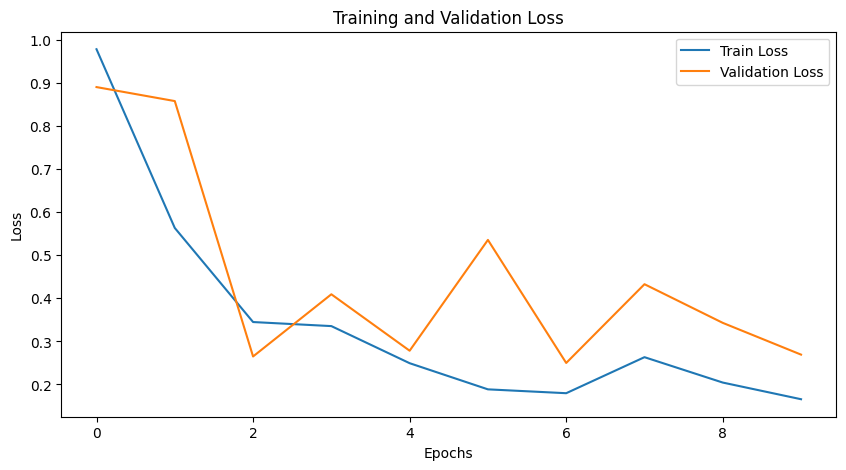

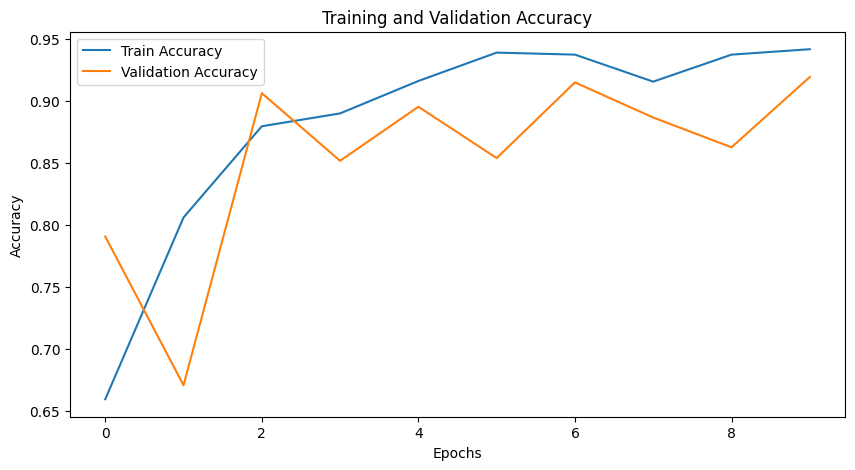

Training type 3 fold 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
epoch 1/10
1/57, train_loss: 1.3680
2/57, train_loss: 1.6241
3/57, train_loss: 1.4786
4/57, train_loss: 1.2421
5/57, train_loss: 2.1824
6/57, train_loss: 1.2346
7/57, train_loss: 1.9396
8/57, train_loss: 1.2637
9/57, train_loss: 1.0513
10/57, train_loss: 1.1635
11/57, train_loss: 0.9459
12/57, train_loss: 0.7189
13/57, train_loss: 0.6163
14/57, train_loss: 0.5020
15/57, train_loss: 0.4527
16/57, train_loss: 0.7825
17/57, train_loss: 0.6476
18/57, train_loss: 0.6816
19/57, train_loss: 0.7491
20/57, train_loss: 0.9287
21/57, train_loss: 0.7230
22/57, train_loss: 0.8108
23/57, train_loss: 0.1656
24/57, train_loss: 1.6393
25/57, train_loss: 0.9177
26/57, train_loss: 1.0908
27/57, train_loss: 0.5253
28/57, train_loss: 0.6339
29/57, train_loss: 0.5930
30/57, train_loss: 0.9573
31/57, train_loss: 1.0604
32/57, train_loss: 0.4941
33/57, train_loss: 0.9297
34/57, train_loss: 0.7648
35/57, train_loss: 0.3483
36/57, train_loss: 1.4316
37/57, train_loss: 0.6947
38/57, train_loss: 0.5643

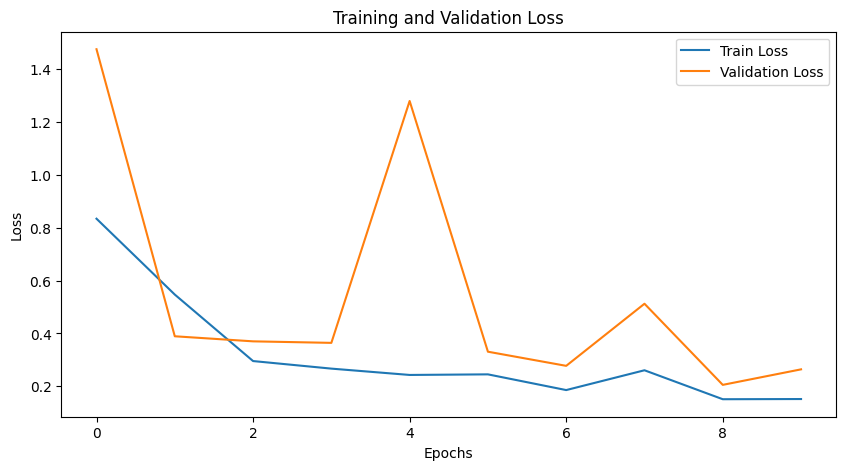

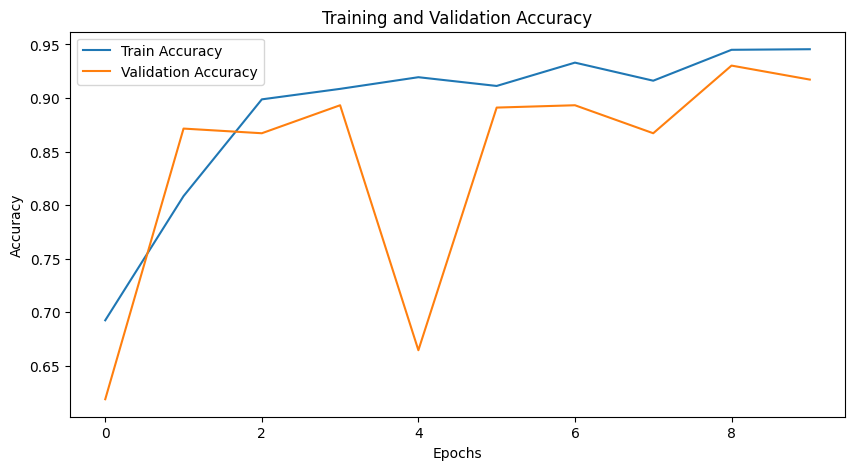

In [ ]:
transforms_train3 = transforms.Compose([
    Transform_to_apply2(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.3),
    transforms.ToTensor()
])

transforms_test3 = transforms.Compose([
    Transform_to_apply2(),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.3),
    transforms.ToTensor()
])

all_test_acc_3 = []
all_test_precision_3 = []
all_test_recall_3 = []
all_test_f1_3 = []
all_test_auc_3 = []

all_validation_acc_3 = {}
all_validation_precision_3 ={}
all_validation_recall_3 = {}
all_validation_f1_3 = {}

for fold_num, (train_index, val_index) in enumerate(folds):
  print(f"Training type 3 fold {fold_num + 1}")
  # Creăm seturile de antrenare și validare pentru acest fold

  all_x = train_x + val_x
  all_y = train_y + val_y
  fold_train_x = [all_x[i] for i in train_index]
  fold_train_y = [all_y[i] for i in train_index]
  fold_val_x = [all_x[i] for i in val_index]
  fold_val_y = [all_y[i] for i in val_index]

  test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, \
  validation_precision_list, validation_recall_list, validation_f1_list, \
  train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list= train_model(
      fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, nn.CrossEntropyLoss(), transforms_train3, transforms_test3
      )

  all_test_auc_3.append(test_performance)
  all_test_acc_3.append(test_acc)
  all_test_precision_3.append(test_precision)
  all_test_recall_3.append(test_recall)
  all_test_f1_3.append(test_f1)
  all_validation_acc_3[fold_num + 1] = validation_acc_list
  all_validation_precision_3[fold_num + 1] = validation_precision_list
  all_validation_recall_3[fold_num + 1]= validation_recall_list
  all_validation_f1_3[fold_num + 1] = validation_f1_list

  # Ploturi loss si acc pentru antrenare si validare
  plt.figure(figsize=(10, 5))
  plt.plot(train_loss_list, label='Train Loss')
  plt.plot(validation_loss_list, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('training_validation_loss_train3_' + str(fold_num + 1) +'.png')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracy_list, label='Train Accuracy')
  plt.plot(validation_accuracy_list, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.savefig('training_validation_accuracy_train3_' + str(fold_num + 1) +'.png')
  plt.show()


**Valori medii set 3**

In [ ]:
# Preluate de la rulare si salvate in cazul deconectarii

# all_test_auc_3 = [0.9160737991333008, 0.8520873785018921, 0.9141887426376343, 0.9063537120819092, 0.9032695293426514]
# all_test_acc_3 = [0.6347826086956522, 0.5032679738562091, 0.6405228758169934, 0.5708061002178649, 0.6383442265795207]
# all_test_precision_3 = [0.7618370650584355, 0.7334973431887671, 0.7825048332026192, 0.7543625248013089, 0.7469495125587442]
# all_test_recall_3 = [0.7411167512690355, 0.5862944162436549, 0.7461928934010152, 0.6649746192893401, 0.7436548223350253]
# all_test_f1_3 = [0.7121674442695003, 0.5396324763591687, 0.7083786741115197, 0.6241611183014617, 0.7244085615125043]

In [ ]:
import statistics

all_test_auc_3 = [float(x) for x in all_test_auc_3]

train3_auc_mean = statistics.mean(all_test_auc_3)
train3_acc_mean = statistics.mean(all_test_acc_3)
train3_precision_mean = statistics.mean(all_test_precision_3)
train3_recall_mean = statistics.mean(all_test_recall_3)
train3_f1_mean = statistics.mean(all_test_f1_3)

train3_means = [train3_precision_mean, train3_recall_mean, train3_f1_mean, train3_auc_mean]
dataset["Set3"] = train3_means
data_performance["Set3"] = all_test_auc_3

print(all_test_auc_3)
print(all_test_acc_3)
print(all_test_precision_3)
print(all_test_recall_3)
print(all_test_f1_3)


[0.9196098446846008, 0.9072510004043579, 0.8510314226150513, 0.9161796569824219, 0.9172706604003906]
[0.7385786802030457, 0.7030456852791879, 0.5913705583756346, 0.7766497461928934, 0.7461928934010152]
[0.7561696441970105, 0.760924274068009, 0.7084197601302352, 0.7802278771189489, 0.8037009648788795]
[0.7385786802030457, 0.7030456852791879, 0.5913705583756346, 0.7766497461928934, 0.7461928934010152]
[0.7191228127777858, 0.666139401196516, 0.5806249224843061, 0.7543732897546057, 0.71955508644093]


In [ ]:
print("Valorile medii pentru metrici per setul de date")
df = pd.DataFrame(dataset)
print(df)
print("\n")
print("Valorile performantelor per fiecare fold")
df = pd.DataFrame(data_performance)
print(df)


Valorile medii pentru metrici per setul de date
     Metrici      Set1      Set2      Set3
0  Precision  0.801521  0.773881  0.761889
1     Recall  0.747208  0.712183  0.711168
2   F1-Score  0.714790  0.669019  0.687963
3        AUC  0.935237  0.910073  0.902269


Valorile performantelor per fiecare fold
   Fold      Set1      Set2      Set3
0     1  0.935731  0.926709  0.919610
1     2  0.932207  0.914887  0.907251
2     3  0.946657  0.905523  0.851031
3     4  0.934676  0.899985  0.916180
4     5  0.926913  0.903258  0.917271


**Cerinta 2.4**

In [ ]:
# Cea mai slaba performanta este pe Setul 3 de transformari pe foldul 3 dupa ce am vazut Cerinta 3
transforms_train3 = transforms.Compose([
    Transform_to_apply2(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.3),
    transforms.ToTensor()
])

transforms_test3 = transforms.Compose([
    Transform_to_apply2(),
    transforms.ColorJitter(brightness=0.35, contrast=0.25, saturation=0.3),
    transforms.ToTensor()
])

train_index, val_index = folds[2]

all_x = train_x + val_x
all_y = train_y + val_y
fold_train_x = [all_x[i] for i in train_index]
fold_train_y = [all_y[i] for i in train_index]
fold_val_x = [all_x[i] for i in val_index]
fold_val_y = [all_y[i] for i in val_index]

data = {
    "Metrici" : ["Accuracy", "Precision", "Recall", "F1-Score", "AUC", "TIME_TRAINING"],
    "Early_Stopping": [],
    "StepLR": []
}


# *Early Stopping*

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_auc = -np.inf
        self.early_stop = False

    def verify(self, val_auc):
        if val_auc > self.best_auc + self.min_delta:
            self.best_auc = val_auc
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import time

def train_model_early(train_x, train_y, val_x, val_y, test_x, test_y, transforms_for_train, transforms_for_test):
  # Create datasets and dataloaders for this fold
  train_ds = BrainTumorDataset(train_x, train_y, transforms_for_train, "train")
  train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
  val_ds = BrainTumorDataset(val_x, val_y, transforms_for_train, "validation")
  val_loader = DataLoader(val_ds, batch_size=32)
  test_ds = BrainTumorDataset(test_x, test_y, transforms_for_test, "test")
  test_loader = DataLoader(test_ds, batch_size=32)

  # Initialize the model, optimizer, loss function (same as before)
  model = models.resnet50(pretrained=True)
  num_features = model.fc.in_features
  model.fc = torch.nn.Linear(num_features, 4)

  use_cuda = torch.cuda.is_available()
  device = "cuda"

  model.to(device)

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  loss_function = nn.CrossEntropyLoss()

  # Early Stopping
  early_stopping = EarlyStopping(patience=3, min_delta=0.01)

  # Training loop (similar to your existing code but with modifications for fold number)
  epochs = 10
  auroc = AUROC(task="multiclass", num_classes=4, average='weighted')
  auroc = auroc.to(device)

  train_loss_list = []
  validation_loss_list = []
  train_accuracy_list = []
  validation_accuracy_list = []
  performance_epoch = []

  validation_f1_list= []
  validation_precision_list = []
  validation_recall_list = []

  y_true = []
  y_pred = []

  best_performance = 0

  # Cronometru
  start_time = time.time()

  for epoch in range(epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    correct_train_preds = 0
    total_train_samples = 0
    step = 0
    for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
      # Reset the b value
      optimizer.zero_grad()
      # Delete the extra dimension
      inputs = inputs.squeeze(1)
      outputs = model(inputs.float())
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
      epoch_len = len(train_ds) // train_loader.batch_size

      _, predicted = torch.max(outputs.data, 1)
      correct_train_preds += (predicted == labels).sum().item()
      total_train_samples += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    train_accuracy = correct_train_preds / total_train_samples
    train_accuracy_list.append(train_accuracy)

    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    train_loss_list.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0
    total_val_samples = 0
    probabilities = []
    targets = []
    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        data = data.squeeze(1)
        output = model(data.float())
        loss = loss_function(output, target)
        val_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        val_acc += (predicted == target).sum().item()
        total_val_samples += target.size(0)

        probs = torch.softmax(output, dim=1)
        probabilities.append(probs)
        targets.append(target)


    validation_accuracy = val_acc / total_val_samples
    validation_accuracy_list.append(validation_accuracy)

    validation_precision_list.append(precision_score(y_true, y_pred, average='weighted'))
    validation_recall_list.append(recall_score(y_true, y_pred, average='weighted'))
    validation_f1_list.append(f1_score(y_true, y_pred, average='weighted'))

    probabilities = torch.cat(probabilities)
    targets = torch.cat(targets)

    performance = auroc(probabilities, targets)
    print(f"Performance: {performance:.4f}")
    performance_epoch.append(performance)


    print(f"Validation Loss: {val_loss/len(val_loader)}")
    validation_loss_list.append(val_loss/len(val_loader))

    # Early stopping
    early_stopping.verify(performance)
    if early_stopping.early_stop:
      print("Early stopping")
      break

  # Stop cronometru
  total_time = time.time() - start_time

  # TESTARE

  model.eval()
  y_test_true = []
  y_test_pred = []
  probs_test = []
  targets_test = []
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data = data.squeeze(1)
      output = model(data.float())
      loss = loss_function(output, target)
      val_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      val_acc += (predicted == target).sum().item()

      y_test_true.extend(target.cpu().numpy())
      y_test_pred.extend(predicted.cpu().numpy())

      probs = torch.softmax(output, dim=1)
      probs_test.append(probs)
      targets_test.append(target)

    print(f"Testing Loss: {val_loss/len(test_loader)}, Testing Accuracy: {val_acc/len(test_ds)}")


  probs_test = torch.cat(probs_test)
  targets_test = torch.cat(targets_test)

  performance = auroc(probs_test, targets_test)

  #Performante pe setul de testare
  accuracy = val_acc/len(test_ds)
  precision = precision_score(y_test_true, y_test_pred, average='weighted')
  recall = recall_score(y_test_true, y_test_pred, average='weighted')
  f1 = f1_score(y_test_true, y_test_pred, average='weighted')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"Performance: {performance}")

  return total_time, performance, accuracy, precision, recall, f1, validation_accuracy_list, validation_precision_list, validation_recall_list, validation_f1_list, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


----------
epoch 1/10


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


1/57, train_loss: 1.4188
2/57, train_loss: 1.4024
3/57, train_loss: 1.4924
4/57, train_loss: 1.3618
5/57, train_loss: 1.4285
6/57, train_loss: 1.1951
7/57, train_loss: 1.3837
8/57, train_loss: 1.0711
9/57, train_loss: 1.2606
10/57, train_loss: 0.9815
11/57, train_loss: 0.9172
12/57, train_loss: 1.3843
13/57, train_loss: 0.7816
14/57, train_loss: 0.6692
15/57, train_loss: 0.8412
16/57, train_loss: 1.0272
17/57, train_loss: 0.4791
18/57, train_loss: 0.6382
19/57, train_loss: 0.8659
20/57, train_loss: 0.9025
21/57, train_loss: 0.4084
22/57, train_loss: 0.3745
23/57, train_loss: 0.7897
24/57, train_loss: 0.4114
25/57, train_loss: 1.0568
26/57, train_loss: 0.6122
27/57, train_loss: 0.2174
28/57, train_loss: 0.3191
29/57, train_loss: 0.8490
30/57, train_loss: 0.7683
31/57, train_loss: 0.7261
32/57, train_loss: 0.4906
33/57, train_loss: 1.0841
34/57, train_loss: 0.5817
35/57, train_loss: 0.3644
36/57, train_loss: 0.8808
37/57, train_loss: 0.8668
38/57, train_loss: 0.5542
39/57, train_loss: 0.

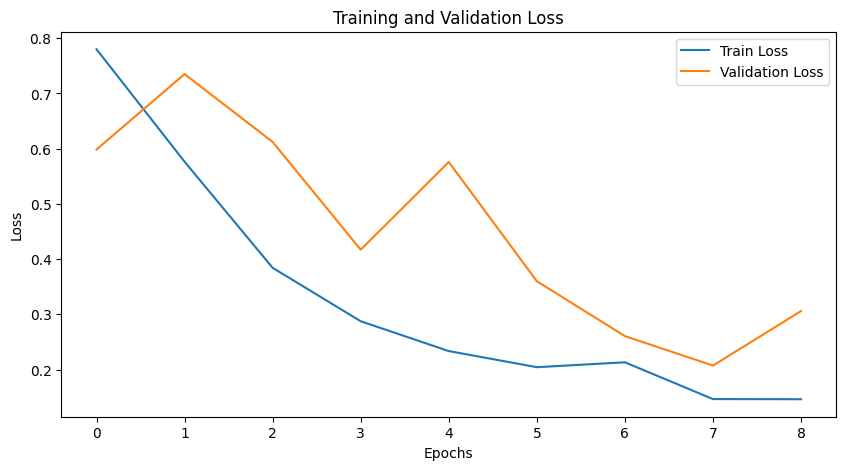

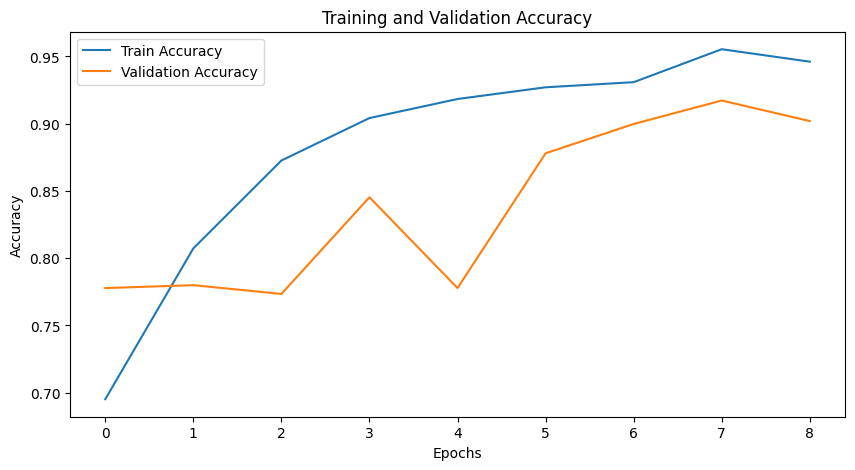

0.682741116751269
0.7034170469608815
0.682741116751269
0.6447801998246161
0.8952393531799316


In [ ]:
timp, test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, \
validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list= train_model_early(
    fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, transforms_train3, transforms_test3
    )

# Ploturi loss si acc pentru antrenare si validare
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_Early_stopping.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy_Early_stopping.png')
plt.show()




#"Accuracy", "Precision", "Recall", "F1-Score", "AUC", "TIME_TRAINING"
data["Early_Stopping"] = [test_acc, test_precision, test_recall, test_f1, float(test_performance), timp]


In [ ]:
test_acc = 0.682741116751269
test_precision = 0.7034170469608815
test_recall = 0.682741116751269
test_f1 = 0.6447801998246161
test_performance =  0.8952393531799316
timp = 401.76348423957825

print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)
print(float(test_performance))

data["Early_Stopping"] = [test_acc, test_precision, test_recall, test_f1, float(test_performance), timp]

0.682741116751269
0.7034170469608815
0.682741116751269
0.6447801998246161
0.8952393531799316


In [ ]:
print("TIMP ANTRENARE Early Stopping : " + str(timp))

TIMP ANTRENARE Early Stopping : 366.7583725452423


# *StepLR*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import time

def train_model_StepLR(train_x, train_y, val_x, val_y, test_x, test_y, transforms_for_train, transforms_for_test):
  # Create datasets and dataloaders for this fold
  train_ds = BrainTumorDataset(train_x, train_y, transforms_for_train, "train")
  train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
  val_ds = BrainTumorDataset(val_x, val_y, transforms_for_train, "validation")
  val_loader = DataLoader(val_ds, batch_size=32)
  test_ds = BrainTumorDataset(test_x, test_y, transforms_for_test, "test")
  test_loader = DataLoader(test_ds, batch_size=32)

  # Initialize the model, optimizer, loss function (same as before)
  model = models.resnet50(pretrained=True)
  num_features = model.fc.in_features
  model.fc = torch.nn.Linear(num_features, 4)

  use_cuda = torch.cuda.is_available()
  device = "cuda"

  model.to(device)

  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  loss_function = nn.CrossEntropyLoss()

  # StepLR
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  # Training loop (similar to your existing code but with modifications for fold number)
  epochs = 10
  auroc = AUROC(task="multiclass", num_classes=4, average='weighted')
  auroc = auroc.to(device)

  train_loss_list = []
  validation_loss_list = []
  train_accuracy_list = []
  validation_accuracy_list = []
  performance_epoch = []

  validation_f1_list= []
  validation_precision_list = []
  validation_recall_list = []

  y_true = []
  y_pred = []

  best_performance = 0

  # Cronometru
  start_time = time.time()

  for epoch in range(epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    correct_train_preds = 0
    total_train_samples = 0
    step = 0
    for batch_data in train_loader:
      step += 1
      inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
      # Reset the b value
      optimizer.zero_grad()
      # Delete the extra dimension
      inputs = inputs.squeeze(1)
      outputs = model(inputs.float())
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
      epoch_len = len(train_ds) // train_loader.batch_size

      _, predicted = torch.max(outputs.data, 1)
      correct_train_preds += (predicted == labels).sum().item()
      total_train_samples += labels.size(0)

      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    train_accuracy = correct_train_preds / total_train_samples
    train_accuracy_list.append(train_accuracy)

    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    train_loss_list.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0
    total_val_samples = 0
    probabilities = []
    targets = []
    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        data = data.squeeze(1)
        output = model(data.float())
        loss = loss_function(output, target)
        val_loss += loss.item()

        _, predicted = torch.max(output.data, 1)
        val_acc += (predicted == target).sum().item()
        total_val_samples += target.size(0)

        probs = torch.softmax(output, dim=1)
        probabilities.append(probs)
        targets.append(target)

    validation_accuracy = val_acc / total_val_samples
    validation_accuracy_list.append(validation_accuracy)

    validation_precision_list.append(precision_score(y_true, y_pred, average='weighted'))
    validation_recall_list.append(recall_score(y_true, y_pred, average='weighted'))
    validation_f1_list.append(f1_score(y_true, y_pred, average='weighted'))

    probabilities = torch.cat(probabilities)
    targets = torch.cat(targets)

    performance = auroc(probabilities, targets)
    print(f"Performance: {performance:.4f}")
    performance_epoch.append(performance)


    print(f"Validation Loss: {val_loss/len(val_loader)}")
    validation_loss_list.append(val_loss/len(val_loader))

    # Actualizare StepLR
    scheduler.step()

  # Stop cronometru
  total_time = time.time() - start_time

  # TESTARE

  model.eval()
  y_test_true = []
  y_test_pred = []
  probs_test = []
  targets_test = []
  val_loss = 0
  val_acc = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data = data.squeeze(1)
      output = model(data.float())
      loss = loss_function(output, target)
      val_loss += loss.item()

      _, predicted = torch.max(output.data, 1)
      val_acc += (predicted == target).sum().item()

      y_test_true.extend(target.cpu().numpy())
      y_test_pred.extend(predicted.cpu().numpy())

      probs = torch.softmax(output, dim=1)
      probs_test.append(probs)
      targets_test.append(target)

    print(f"Testing Loss: {val_loss/len(test_loader)}, Testing Accuracy: {val_acc/len(test_ds)}")


  probs_test = torch.cat(probs_test)
  targets_test = torch.cat(targets_test)

  performance = auroc(probs_test, targets_test)

  #Performante pe setul de testare
  accuracy = val_acc/len(test_ds)
  precision = precision_score(y_test_true, y_test_pred, average='weighted')
  recall = recall_score(y_test_true, y_test_pred, average='weighted')
  f1 = f1_score(y_test_true, y_test_pred, average='weighted')

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")
  print(f"Performance: {performance}")

  return total_time, performance, accuracy, precision, recall, f1, validation_accuracy_list, validation_precision_list, validation_recall_list, validation_f1_list, train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


----------
epoch 1/10


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


1/57, train_loss: 1.4135
2/57, train_loss: 1.3619
3/57, train_loss: 1.3522
4/57, train_loss: 1.2596
5/57, train_loss: 1.1585
6/57, train_loss: 1.4685
7/57, train_loss: 1.3972
8/57, train_loss: 1.6688
9/57, train_loss: 1.3582
10/57, train_loss: 1.4347
11/57, train_loss: 1.1145
12/57, train_loss: 0.7826
13/57, train_loss: 1.0252
14/57, train_loss: 1.2799
15/57, train_loss: 1.2538
16/57, train_loss: 0.2615
17/57, train_loss: 0.8560
18/57, train_loss: 1.3962
19/57, train_loss: 1.1185
20/57, train_loss: 1.3641
21/57, train_loss: 1.1139
22/57, train_loss: 1.6071
23/57, train_loss: 2.3123
24/57, train_loss: 1.1937
25/57, train_loss: 0.7766
26/57, train_loss: 1.3318
27/57, train_loss: 0.7776
28/57, train_loss: 0.8438
29/57, train_loss: 1.3622
30/57, train_loss: 1.1353
31/57, train_loss: 2.5637
32/57, train_loss: 1.7744
33/57, train_loss: 1.0735
34/57, train_loss: 0.8475
35/57, train_loss: 0.6090
36/57, train_loss: 1.5241
37/57, train_loss: 0.9283
38/57, train_loss: 0.6118
39/57, train_loss: 0.

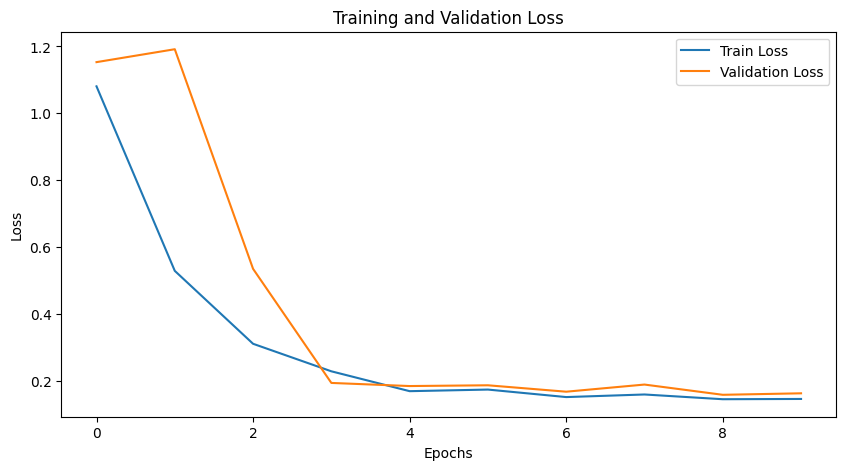

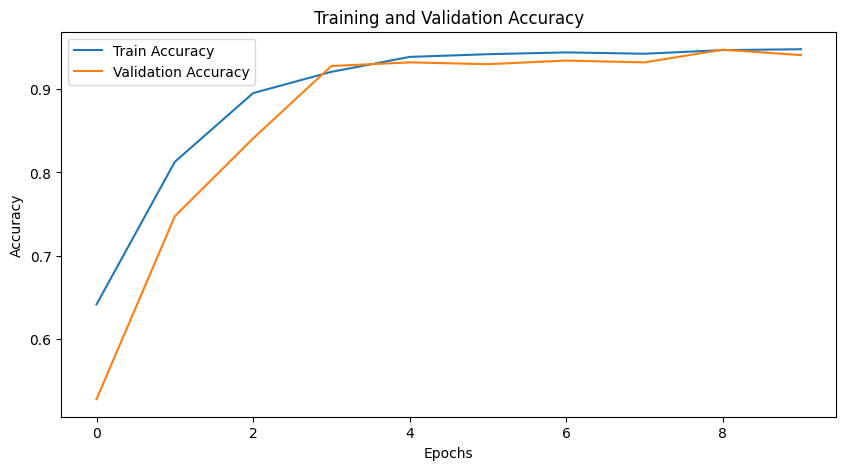

In [ ]:
timp, test_performance, test_acc, test_precision, test_recall, test_f1, validation_acc_list, \
validation_precision_list, validation_recall_list, validation_f1_list, \
train_loss_list, validation_loss_list, train_accuracy_list, validation_accuracy_list= train_model_StepLR(
    fold_train_x, fold_train_y, fold_val_x, fold_val_y, test_x, test_y, transforms_train3, transforms_test3
    )

# Ploturi loss si acc pentru antrenare si validare
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_validation_loss_StepLR.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training_validation_accuracy_StepLR.png')
plt.show()

data["StepLR"] = [test_acc, test_precision, test_recall, test_f1, float(test_performance), timp]


In [ ]:
test_acc = 0.7182741116751269
test_precision = 0.7503378847377948
test_recall = 0.7182741116751269
test_f1 = 0.6920960100682173
test_performance = 0.9116090536117554
timp = 414.4376611709595

print(test_acc)
print(test_precision)
print(test_recall)
print(test_f1)
print(float(test_performance))

data["StepLR"] = [test_acc, test_precision, test_recall, test_f1, float(test_performance), timp]


0.7182741116751269
0.7503378847377948
0.7182741116751269
0.6920960100682173
0.9116090536117554


In [ ]:
print("TIMP ANTRENARE StepLR : " + str(timp))

TIMP ANTRENARE StepLR : 414.4376611709595


In [ ]:
import pandas as pd

df = pd.DataFrame(data)

print(df)

         Metrici  Early_Stopping      StepLR
0       Accuracy        0.682741    0.718274
1      Precision        0.703417    0.750338
2         Recall        0.682741    0.718274
3       F1-Score        0.644780    0.692096
4            AUC        0.895239    0.911609
5  TIME_TRAINING      401.763484  414.437661
